In [1]:
# Librerías estándar y manipulación de archivos
import os
import joblib

# Manipulación de datos y operaciones básicas
import numpy as np

# Visualización de datos
import matplotlib.pyplot as plt
import seaborn as sns

# Modelos de Machine Learning
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

# Selección y validación de modelos
from sklearn.model_selection import GridSearchCV, StratifiedKFold,  cross_val_score, KFold

# Métricas de evaluación
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score, roc_curve, auc

# Configuraciones adicionales
import warnings

#Se importan las librerias necesarias para el uso de pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from pytorch_tabnet.tab_model import TabNetClassifier


# Se ignoran los warnings en el notebook
warnings.filterwarnings('ignore')

# Se define el dispositivo a utilizar
print(torch.__version__)
print("CUDA disponible:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Número de GPU disponibles:", torch.cuda.device_count())
    print("Nombre de la GPU 0:", torch.cuda.get_device_name(0))
    print("Dispositivo actual:", torch.cuda.current_device())

# Se define el dispositivo a utilizar
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

2.3.1+cu121
CUDA disponible: True
Número de GPU disponibles: 1
Nombre de la GPU 0: NVIDIA GeForce RTX 3090
Dispositivo actual: 0


In [2]:
def evaluar_modelo_sklearn(model, X_train, y_train, X_test, y_test, dataset_name, model_name):
    # Evaluación con datos de entrenamiento
    y_pred_train = model.predict(X_train)
    y_pred_train_prob = model.predict_proba(X_train)[:, 1]

    # Cálculo de métricas para datos de entrenamiento
    accuracy_train = accuracy_score(y_train, y_pred_train)
    precision_train = precision_score(y_train, y_pred_train)
    recall_train = recall_score(y_train, y_pred_train)
    f1_train = f1_score(y_train, y_pred_train)

    # Visualización de métricas y gráficos para datos de entrenamiento
    print('\033[1m' + '.' * len("Resultados datos de entrenamiento:") + '\n' + "Resultados datos de entrenamiento:" + '\033[0m')
    print(f"Accuracy (Datos de Train): {accuracy_train}")
    print(f"Precision (Datos de Train): {precision_train}")
    print(f"Recall (Datos de Train): {recall_train}")
    print(f"F1 Score (Datos de Train): {f1_train}")

    # Gráficos para datos de entrenamiento
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(f'Resultados de Train {model_name} para el Dataset: - {dataset_name}', fontsize=16, fontweight='bold', y=1.05)
    conf_matrix_train = confusion_matrix(y_train, y_pred_train)
    sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Blues', ax=axes[0],
                xticklabels=['Asiste', 'No-show'], yticklabels=['Asiste', 'No-show'])
    axes[0].set_title('Matriz de Confusión (Datos de Train)')
    axes[0].set_xlabel('Predicho')
    axes[0].set_ylabel('Real')
    print(conf_matrix_train)

    fpr_train, tpr_train, _ = roc_curve(y_train, y_pred_train_prob)
    roc_auc_train = auc(fpr_train, tpr_train)
    axes[1].plot(fpr_train, tpr_train, color='darkorange', lw=2, label=f'AUC = {roc_auc_train:.2f}')
    axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_title('Curva ROC (Datos de Train)')
    axes[1].set_xlabel('Tasa de Falsos Positivos')
    axes[1].set_ylabel('Tasa de Verdaderos Positivos')
    axes[1].legend(loc="lower right")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    # Evaluación con datos de prueba
    y_pred_test = model.predict(X_test)
    y_pred_test_prob = model.predict_proba(X_test)[:, 1]

    # Cálculo de métricas para datos de prueba
    accuracy_test = accuracy_score(y_test, y_pred_test)
    precision_test = precision_score(y_test, y_pred_test)
    recall_test = recall_score(y_test, y_pred_test)
    f1_test = f1_score(y_test, y_pred_test)

    # Visualización de métricas y gráficos para datos de prueba
    print('\033[1m' + '.' * len("Resultados datos de test:") + '\n' + "Resultados datos de test:" + '\033[0m')
    print(f"Accuracy (Datos de Test): {accuracy_test}")
    print(f"Precision (Datos de Test): {precision_test}")
    print(f"Recall (Datos de Test): {recall_test}")
    print(f"F1 Score (Datos de Test): {f1_test}")

    # Gráficos para datos de prueba
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(f'Resultados de Test {model_name} para el Dataset: - {dataset_name}', fontsize=16, fontweight='bold', y=1.05)
    conf_matrix_test = confusion_matrix(y_test, y_pred_test)
    sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Reds', ax=axes[0],
                xticklabels=['Asiste', 'No-show'], yticklabels=['Asiste', 'No-show'])
    axes[0].set_title('Matriz de Confusión (Datos de Test)')
    axes[0].set_xlabel('Predicho')
    axes[0].set_ylabel('Real')
    print(conf_matrix_test)

    fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_test_prob)
    roc_auc_test = auc(fpr_test, tpr_test)
    axes[1].plot(fpr_test, tpr_test, color='darkorange', lw=2, label=f'AUC = {roc_auc_test:.2f}')
    axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_title('Curva ROC (Datos de Test)')
    axes[1].set_xlabel('Tasa de Falsos Positivos')
    axes[1].set_ylabel('Tasa de Verdaderos Positivos')
    axes[1].legend(loc="lower right")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

In [3]:
def execute_model_logistic_regression(X, y, X_test, y_test, dataset_name):
    model_dir = 'models'
    model_name = 'Regresión Logística'
    os.makedirs(model_dir, exist_ok=True)
    model_filename = os.path.join(model_dir, f'modelo_logistic_regression_{dataset_name}.joblib')
    params_log_filename = os.path.join(model_dir, f'modelo_logistic_regression_{dataset_name}_params.txt')

    if os.path.exists(model_filename):
        model = joblib.load(model_filename)
        print("Modelo cargado exitosamente.")
        if os.path.exists(params_log_filename):
            with open(params_log_filename, 'r') as f:
                best_params = f.read()
                print(f"Mejores hiperparámetros cargados: {best_params}")
        else:
            print("No se encontraron hiperparámetros guardados.")
        evaluar_modelo_sklearn(model, X, y, X_test, y_test, dataset_name, model_name)
        return

    # Se define el rango de hiperparámetros para la búsqueda en cuadrícula
    param_grid = {
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
        'max_iter': [100, 200, 300, 500, 1000]
    }

    # Configura la búsqueda en cuadrícula
    grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    best_score = 0
    best_model = None
    best_params = None

    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        grid_search.fit(X_train, y_train)
        candidate_model = grid_search.best_estimator_
        val_score = accuracy_score(y_val, candidate_model.predict(X_val))

        if val_score > best_score:
            best_score = val_score
            best_model = candidate_model
            best_params = grid_search.best_params_

    print(f"Mejores hiperparámetros: {best_params}")
    print(f"Mejor puntaje de validación: {best_score}")

    # Guardar los mejores hiperparámetros en un archivo de registro
    with open(params_log_filename, 'w') as f:
        f.write(str(best_params))

    # Guarda el mejor modelo
    joblib.dump(best_model, model_filename)
    print(f"Modelo guardado en {model_filename}")

    # Evalúa el mejor modelo
    evaluar_modelo_sklearn(best_model, X, y, X_test, y_test, dataset_name, model_name)

# Suponiendo que evaluar_modelo_sklearn está definida en otro lugar y no se puede editar.


In [4]:
def execute_model_decision_tree(X, y, X_test, y_test, dataset_name):
    model_dir = 'models'
    model_name = 'Árbol de Decisión'
    os.makedirs(model_dir, exist_ok=True)
    model_filename = os.path.join(model_dir, f'modelo_decision_tree_{dataset_name}.joblib')
    params_log_filename = os.path.join(model_dir, f'modelo_decision_tree_{dataset_name}_params.txt')

    if os.path.exists(model_filename):
        model = joblib.load(model_filename)
        print("Modelo cargado exitosamente.")
        if os.path.exists(params_log_filename):
            with open(params_log_filename, 'r') as f:
                best_params = f.read()
                print(f"Mejores hiperparámetros cargados: {best_params}")
        else:
            print("No se encontraron hiperparámetros guardados.")
        evaluar_modelo_sklearn(model, X, y, X_test, y_test, dataset_name, model_name)
        return

    # Se define el rango de hiperparámetros para la búsqueda en cuadrícula
    param_grid = {
        'criterion': ['gini', 'entropy'],
        'max_depth': [10, 15, 20],
        'min_samples_split': [2, 3, 5],
        'min_samples_leaf': [2, 3, 4]
    }

    # Configura la búsqueda en cuadrícula
    grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    best_score = 0
    best_model = None
    best_params = None

    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        grid_search.fit(X_train, y_train)
        candidate_model = grid_search.best_estimator_
        val_score = accuracy_score(y_val, candidate_model.predict(X_val))

        if val_score > best_score:
            best_score = val_score
            best_model = candidate_model
            best_params = grid_search.best_params_

    print(f"Mejores hiperparámetros: {best_params}")
    print(f"Mejor puntaje de validación: {best_score}")

    # Guardar los mejores hiperparámetros en un archivo de registro
    with open(params_log_filename, 'w') as f:
        f.write(str(best_params))

    # Guarda el mejor modelo
    joblib.dump(best_model, model_filename)
    print(f"Modelo guardado en {model_filename}")

    # Evalúa el mejor modelo
    evaluar_modelo_sklearn(best_model, X, y, X_test, y_test, dataset_name, model_name)

In [5]:
# Se define la funcion para graficar la perdida por epoca para red neuronal de pytorch
def graficar_progreso(losses, inicio_folds, dataset_name, grado=3):
    plt.figure(figsize=(20, 10))
    # Gráfico original
    plt.plot(range(1, len(losses) + 1), losses, marker='o', linestyle='-', color='blue', label='Pérdida Real')

     # Marcar y anotar el inicio de cada fold
    for i, inicio in enumerate(inicio_folds):
        plt.axvline(x=inicio, color='black', linestyle='--', lw=1)
        plt.text(inicio, max(losses)*0.95, f'Inicio Fold {i+1}', rotation=90, color='black', fontsize=12, fontweight='bold')

    # Ajustando la curva de tendencia
    z = np.polyfit(range(1, len(losses) + 1), losses, grado)  # Ajuste polinomial
    p = np.poly1d(z)  # Creación de un polinomio
    plt.plot(range(1, len(losses) + 1), p(range(1, len(losses) + 1)), "r--", label='Curva de Tendencia')  # Curva de tendencia en rojo

    # Configuración del gráfico
    plt.title(f'Pérdida por Época a través de los Folds, Dataset: {dataset_name}')
    plt.xlabel('Época Total')
    plt.ylabel('Pérdida')
    plt.legend()
    plt.grid(True)
    plt.show()


In [6]:
def evaluar_modelo_pytorch(model, X_train_tensor, y_train, X_test_tensor, y_test, dataset_name):
    # Evaluación con datos de entrenamiento
    y_pred = model(X_train_tensor).detach().cpu().numpy()
    y_pred_bin = (y_pred > 0.5).astype(int)

    # Cálculo de métricas para datos de entrenamiento
    accuracy = accuracy_score(y_train, y_pred_bin)
    precision = precision_score(y_train, y_pred_bin)
    recall = recall_score(y_train, y_pred_bin)
    f1 = f1_score(y_train, y_pred_bin)

    # Visualización de métricas y gráficos para datos de entrenamiento
    print('\033[1m' + '.' * len("Resultados datos de entrenamiento:") + '\n' + "Resultados datos de entrenamiento:" + '\033[0m')
    print(f"Accuracy (Datos de Train): {accuracy}")
    print(f"Precision (Datos de Train): {precision}")
    print(f"Recall (Datos de Train): {recall}")
    print(f"F1 Score (Datos de Train): {f1}")

    # Gráficos para datos de entrenamiento
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(f'Resultados de Train Red Neuronal para el Dataset: - {dataset_name}', fontsize=16, fontweight='bold', y=1.05)
    conf_matrix = confusion_matrix(y_train, y_pred_bin)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[0],
                xticklabels=['Asiste', 'No-show'], yticklabels=['Asiste', 'No-show'])
    axes[0].set_title('Matriz de Confusión (Datos de Train)')
    axes[0].set_xlabel('Predicho')
    axes[0].set_ylabel('Real')
    print(conf_matrix)

    fpr, tpr, thresholds = roc_curve(y_train, y_pred)
    roc_auc = auc(fpr, tpr)
    axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
    axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_title('Curva ROC (Datos de Train)')
    axes[1].set_xlabel('Tasa de Falsos Positivos')
    axes[1].set_ylabel('Tasa de Verdaderos Positivos')
    axes[1].legend(loc="lower right")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    # Evaluación con datos de prueba
    y_pred_test = model(X_test_tensor).detach().cpu().numpy()
    y_pred_test_bin = (y_pred_test > 0.5).astype(int)

    # Cálculo de métricas para datos de prueba
    accuracy_test = accuracy_score(y_test, y_pred_test_bin)
    precision_test = precision_score(y_test, y_pred_test_bin)
    recall_test = recall_score(y_test, y_pred_test_bin)
    f1_test = f1_score(y_test, y_pred_test_bin)

    # Visualización de métricas y gráficos para datos de prueba
    print('\033[1m' + '.' * len("Resultados datos de test:") + '\n' + "Resultados datos de test:" + '\033[0m')
    print(f"Accuracy (Datos de Test): {accuracy_test}")
    print(f"Precision (Datos de Test): {precision_test}")
    print(f"Recall (Datos de Test): {recall_test}")
    print(f"F1 Score (Datos de Test): {f1_test}")

    # Gráficos para datos de prueba
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(f'Resultados de Test Red Neuronal para el Dataset: - {dataset_name}', fontsize=16, fontweight='bold', y=1.05)
    conf_matrix_test = confusion_matrix(y_test, y_pred_test_bin)
    sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Reds', ax=axes[0],
                xticklabels=['Asiste', 'No-show'], yticklabels=['Asiste', 'No-show'])
    axes[0].set_title('Matriz de Confusión (Datos de Test)')
    axes[0].set_xlabel('Predicho')
    axes[0].set_ylabel('Real')
    print(conf_matrix_test)

    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_pred_test)
    roc_auc_test = auc(fpr_test, tpr_test)
    axes[1].plot(fpr_test, tpr_test, color='darkorange', lw=2, label=f'AUC = {roc_auc_test:.2f}')
    axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_title('Curva ROC (Datos de Test)')
    axes[1].set_xlabel('Tasa de Falsos Positivos')
    axes[1].set_ylabel('Tasa de Verdaderos Positivos')
    axes[1].legend(loc="lower right")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


In [7]:
def evaluar_modelo_tabnet(model, X_train, y_train, X_test, y_test, dataset_name):
    # Evaluación con datos de entrenamiento
    y_pred = model.predict_proba(X_train)[:, 1]
    y_pred_bin = (y_pred > 0.5).astype(int)

    # Cálculo de métricas para datos de entrenamiento
    accuracy = accuracy_score(y_train, y_pred_bin)
    precision = precision_score(y_train, y_pred_bin)
    recall = recall_score(y_train, y_pred_bin)
    f1 = f1_score(y_train, y_pred_bin)

    # Visualización de métricas y gráficos para datos de entrenamiento
    print('\033[1m' + '.' * len("Resultados datos de entrenamiento:") + '\n' + "Resultados datos de entrenamiento:" + '\033[0m')
    print(f"Accuracy (Datos de Train): {accuracy}")
    print(f"Precision (Datos de Train): {precision}")
    print(f"Recall (Datos de Train): {recall}")
    print(f"F1 Score (Datos de Train): {f1}")

    # Gráficos para datos de entrenamiento
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(f'Resultados de Train TabNet para el Dataset: - {dataset_name}', fontsize=16, fontweight='bold', y=1.05)
    conf_matrix = confusion_matrix(y_train, y_pred_bin)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[0],
                xticklabels=['Asiste', 'No-show'], yticklabels=['Asiste', 'No-show'])
    axes[0].set_title('Matriz de Confusión (Datos de Train)')
    axes[0].set_xlabel('Predicho')
    axes[0].set_ylabel('Real')
    print(conf_matrix)

    fpr, tpr, thresholds = roc_curve(y_train, y_pred)
    roc_auc = auc(fpr, tpr)
    axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
    axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_title('Curva ROC (Datos de Train)')
    axes[1].set_xlabel('Tasa de Falsos Positivos')
    axes[1].set_ylabel('Tasa de Verdaderos Positivos')
    axes[1].legend(loc="lower right")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    # Evaluación con datos de prueba
    y_pred_test = model.predict_proba(X_test)[:, 1]
    y_pred_test_bin = (y_pred_test > 0.5).astype(int)

    # Cálculo de métricas para datos de prueba
    accuracy_test = accuracy_score(y_test, y_pred_test_bin)
    precision_test = precision_score(y_test, y_pred_test_bin)
    recall_test = recall_score(y_test, y_pred_test_bin)
    f1_test = f1_score(y_test, y_pred_test_bin)

    # Visualización de métricas y gráficos para datos de prueba
    print('\033[1m' + '.' * len("Resultados datos de test:") + '\n' + "Resultados datos de test:" + '\033[0m')
    print(f"Accuracy (Datos de Test): {accuracy_test}")
    print(f"Precision (Datos de Test): {precision_test}")
    print(f"Recall (Datos de Test): {recall_test}")
    print(f"F1 Score (Datos de Test): {f1_test}")

    # Gráficos para datos de prueba
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(f'Resultados de Test TabNet para el Dataset: - {dataset_name}', fontsize=16, fontweight='bold', y=1.05)
    conf_matrix_test = confusion_matrix(y_test, y_pred_test_bin)
    sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Reds', ax=axes[0],
                xticklabels=['Asiste', 'No-show'], yticklabels=['Asiste', 'No-show'])
    axes[0].set_title('Matriz de Confusión (Datos de Test)')
    axes[0].set_xlabel('Predicho')
    axes[0].set_ylabel('Real')
    print(conf_matrix_test)

    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_pred_test)
    roc_auc_test = auc(fpr_test, tpr_test)
    axes[1].plot(fpr_test, tpr_test, color='darkorange', lw=2, label=f'AUC = {roc_auc_test:.2f}')
    axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_title('Curva ROC (Datos de Test)')
    axes[1].set_xlabel('Tasa de Falsos Positivos')
    axes[1].set_ylabel('Tasa de Verdaderos Positivos')
    axes[1].legend(loc="lower right")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

In [8]:
# Se define la función para ejecutar el modelo en PyTorch de NeuralNet
def execute_model_pytorch(X_train, y_train, X_test, y_test, device, dataset_name):
    class NeuralNet(nn.Module):
        def __init__(self, input_size):
            super(NeuralNet, self).__init__()
            self.layer1 = nn.Linear(input_size, 64)
            self.bn1 = nn.BatchNorm1d(64)
            self.relu1 = nn.ReLU()

            self.layer2 = nn.Linear(64, 32)
            self.bn2 = nn.BatchNorm1d(32)
            self.relu2 = nn.ReLU()
            self.dropout1 = nn.Dropout(0.5)

            self.output_layer = nn.Linear(32, 1)
            self.sigmoid = nn.Sigmoid()

        def forward(self, x):
            out = self.bn1(self.layer1(x))
            out = self.relu1(out)

            out = self.bn2(self.layer2(out))
            out = self.relu2(out)
            out = self.dropout1(out)

            out = self.output_layer(out)
            out = self.sigmoid(out)
            return out

    model = NeuralNet(X_train.shape[1]).to(device)

    model_dir = 'models'
    os.makedirs(model_dir, exist_ok=True)
    model_filename = os.path.join(model_dir, f'modelo_pytorch_{dataset_name}.pth')

    if os.path.exists(model_filename):
        model.load_state_dict(torch.load(model_filename))
        print("Modelo cargado exitosamente.")

        X_test_tensor = torch.tensor(X_test).float().to(device)
        X_train_fold_tensor = torch.tensor(X_train).float().to(device)
        y_train_fold = y_train
        evaluar_modelo_pytorch(model, X_train_fold_tensor, y_train_fold, X_test_tensor, y_test, dataset_name)
        return

    skfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    num_epochs = 100
    patience = 10  # Número de épocas a esperar antes de detener el entrenamiento si no hay mejora
    fold_results = []
    losses = []
    inicio_folds = [1]
    epoca_actual = 0

    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5) 
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

    best_global_val_loss = float('inf')
    best_model_state = None

    for fold, (train_index, test_index) in enumerate(skfolds.split(X_train, y_train)):
        print(f'Comenzando el fold {fold+1}')

        X_train_fold = X_train[train_index]
        y_train_fold = y_train[train_index]
        X_valid_fold = X_train[test_index]
        y_valid_fold = y_train[test_index]

        X_train_fold_tensor = torch.tensor(X_train_fold).float().to(device)
        y_train_fold_tensor = torch.tensor(y_train_fold.to_numpy()[:, None]).float().to(device)
        X_valid_fold_tensor = torch.tensor(X_valid_fold).float().to(device)
        y_valid_fold_tensor = torch.tensor(y_valid_fold.to_numpy()[:, None]).float().to(device)

        train_loader = DataLoader(TensorDataset(X_train_fold_tensor, y_train_fold_tensor), batch_size=64, shuffle=True)
        valid_loader = DataLoader(TensorDataset(X_valid_fold_tensor, y_valid_fold_tensor), batch_size=64)

        epoch_losses = []
        best_val_loss = float('inf')
        patience_counter = 0

        for epoch in range(num_epochs):
            model.train()
            train_losses = []
            for inputs, targets in train_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
                train_losses.append(loss.item())

            model.eval()
            val_losses = []
            with torch.no_grad():
                for inputs, targets in valid_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    val_losses.append(loss.item())

            epoch_train_loss = torch.tensor(train_losses).mean().item()
            epoch_val_loss = torch.tensor(val_losses).mean().item()
            epoch_losses.append((epoch_train_loss, epoch_val_loss))
            losses.append(epoch_val_loss)
            print(f'Fold {fold+1}, Epoch {epoch+1}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}')

            # Step the scheduler
            scheduler.step(epoch_val_loss)

            # Early Stopping
            if epoch_val_loss < best_val_loss:
                best_val_loss = epoch_val_loss
                patience_counter = 0
                # Guardar el mejor modelo del fold actual
                if epoch_val_loss < best_global_val_loss:
                    best_global_val_loss = epoch_val_loss
                    best_model_state = model.state_dict()
            else:
                patience_counter += 1

            if patience_counter >= patience and epoch >= (num_epochs // 2):  # Modificar la condición de stop
                print(f'Early stopping en la época {epoch+1}')
                break

        fold_results.append({
            'fold': fold+1,
            'epoch_losses': epoch_losses,
        })
        if fold < skfolds.n_splits - 1:
            epoca_actual += num_epochs
            inicio_folds.append(epoca_actual + 1)

    # Guardar el mejor modelo global
    torch.save(best_model_state, model_filename)
    print(f"Mejor modelo guardado en {model_filename}")

    graficar_progreso(losses, inicio_folds, dataset_name, grado=3)

    X_test_tensor = torch.tensor(X_test).float().to(device)

    X_train_fold_tensor = torch.tensor(X_train).float().to(device)
    y_train_fold = y_train

    evaluar_modelo_pytorch(model, X_train_fold_tensor, y_train_fold, X_test_tensor, y_test, dataset_name)


In [9]:
def execute_model_tabnet(X_train, y_train, X_test, y_test, device, dataset_name, num_epochs=100, patience=10):
    # Convertir los datos a numpy arrays si no lo están ya
    X_train = X_train.to_numpy() if hasattr(X_train, 'to_numpy') else X_train
    X_test = X_test.to_numpy() if hasattr(X_test, 'to_numpy') else X_test
    y_train = y_train.to_numpy() if hasattr(y_train, 'to_numpy') else y_train
    y_test = y_test.to_numpy() if hasattr(y_test, 'to_numpy') else y_test

    # Parámetros del modelo
    model_params = dict(
        n_d=64, n_a=64, n_steps=5,
        gamma=1.5, n_independent=2, n_shared=2,
        cat_idxs=[], cat_dims=[], cat_emb_dim=[],
        lambda_sparse=1e-3, momentum=0.3, clip_value=2.,
        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=2e-2),
        scheduler_params={"step_size":10, "gamma":0.9},
        scheduler_fn=torch.optim.lr_scheduler.StepLR,
        epsilon=1e-15,
        device_name=device
    )

    model_dir = 'models'
    os.makedirs(model_dir, exist_ok=True)
    model_filename = os.path.join(model_dir, f'modelo_tabnet_{dataset_name}.pkl')

    if os.path.exists(model_filename):
        try:
            model = joblib.load(model_filename)
            print("Modelo cargado exitosamente.")
            evaluar_modelo_tabnet(model, X_train, y_train, X_test, y_test, dataset_name)
            return
        except Exception as e:
            print(f"Error al cargar el modelo: {e}. Procediendo con el entrenamiento.")

    skfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    fold_results = []
    losses = []
    inicio_folds = [1]
    epoca_actual = 0

    best_global_val_auc = 0
    best_model = None

    for fold, (train_index, valid_index) in enumerate(skfolds.split(X_train, y_train), 1):
        print(f'Comenzando el fold {fold}')

        X_train_fold, X_valid_fold = X_train[train_index], X_train[valid_index]
        y_train_fold, y_valid_fold = y_train[train_index], y_train[valid_index]

        try:
            # Inicializar un nuevo modelo para cada fold
            model = TabNetClassifier(**model_params)

            # Fit del modelo
            model.fit(
                X_train=X_train_fold, y_train=y_train_fold,
                eval_set=[(X_valid_fold, y_valid_fold)],
                eval_name=['valid'],
                eval_metric=['auc'],
                max_epochs=num_epochs, patience=patience,
                batch_size=1024, virtual_batch_size=128
            )

            # Guardar las métricas
            epoch_metrics = model.history['valid_auc']
            if epoch_metrics:
                losses.extend([-auc for auc in epoch_metrics])  # Convertimos AUC a pérdida
                fold_results.append({
                    'fold': fold,
                    'epoch_metrics': epoch_metrics,
                })
                print(f"Fold {fold} completado. Métricas registradas: {len(epoch_metrics)}")

                # Actualizar el mejor modelo global
                best_fold_auc = max(epoch_metrics)
                if best_fold_auc > best_global_val_auc:
                    best_global_val_auc = best_fold_auc
                    best_model = model

                if fold < skfolds.n_splits:
                    epoca_actual += len(epoch_metrics)
                    inicio_folds.append(epoca_actual + 1)
            else:
                print(f"Advertencia: No se registraron métricas para el fold {fold}")

        except Exception as e:
            print(f"Error en el fold {fold}: {e}")

    if losses:
        graficar_progreso(losses, inicio_folds, dataset_name, grado=3)
    else:
        print("No se registraron métricas durante el entrenamiento. No se puede graficar el progreso.")
   
    if best_model is not None:
        joblib.dump(best_model, model_filename)
        print(f"Mejor modelo guardado en {model_filename}")
        
        # Evaluación final
        evaluar_modelo_tabnet(best_model, X_train, y_train, X_test, y_test, dataset_name)
    else:
        print("No se pudo entrenar ningún modelo exitosamente.")


Ejecutando modelo para el dataset: P1-ALL-ADASYN

Modelo cargado exitosamente.
Mejores hiperparámetros cargados: {'C': 10, 'max_iter': 100, 'solver': 'lbfgs'}
..................................
Resultados datos de entrenamiento:
Accuracy (Datos de Train): 0.6087605629719819
Precision (Datos de Train): 0.6286347907545835
Recall (Datos de Train): 0.4875669103364422
F1 Score (Datos de Train): 0.5491866252463506
[[51116 19425]
 [34559 32882]]


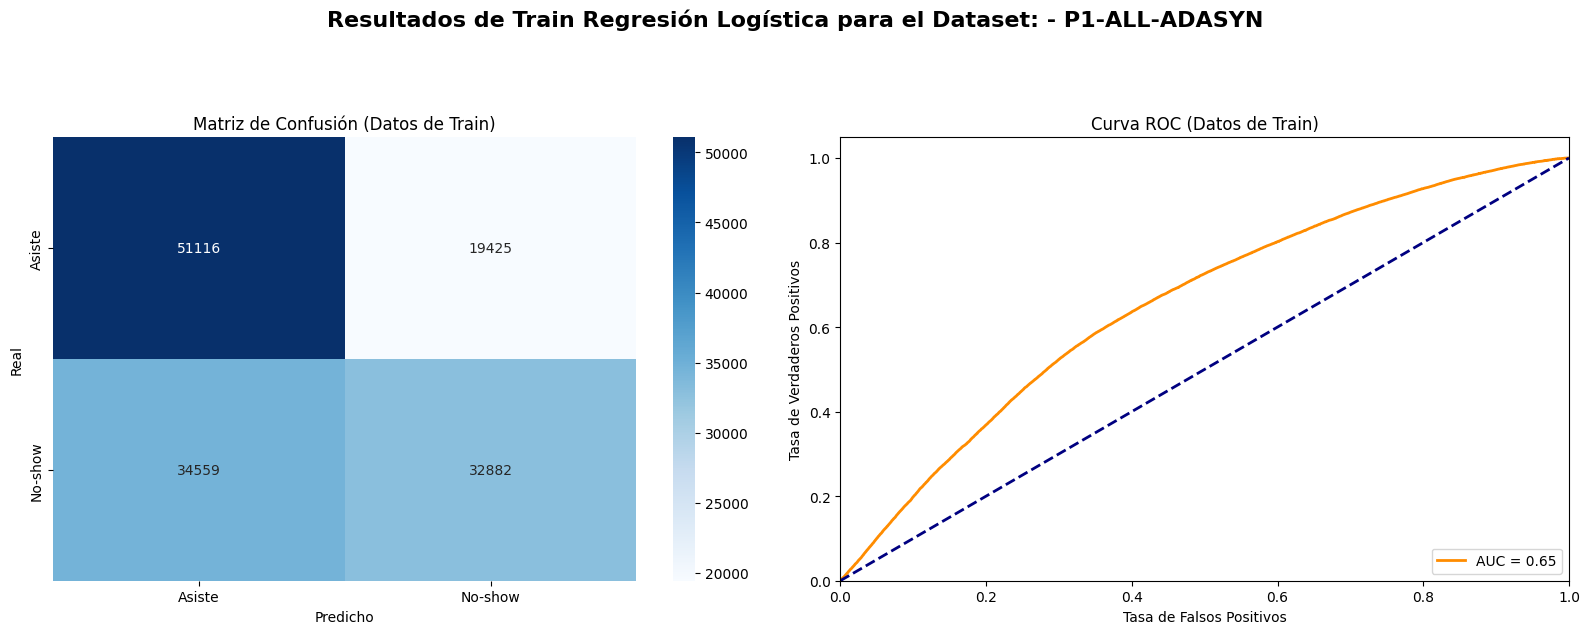

.........................
Resultados datos de test:
Accuracy (Datos de Test): 0.6456985111101055
Precision (Datos de Test): 0.3069692801467217
Recall (Datos de Test): 0.600313830979601
F1 Score (Datos de Test): 0.4062191884717482
[[11590  6046]
 [ 1783  2678]]


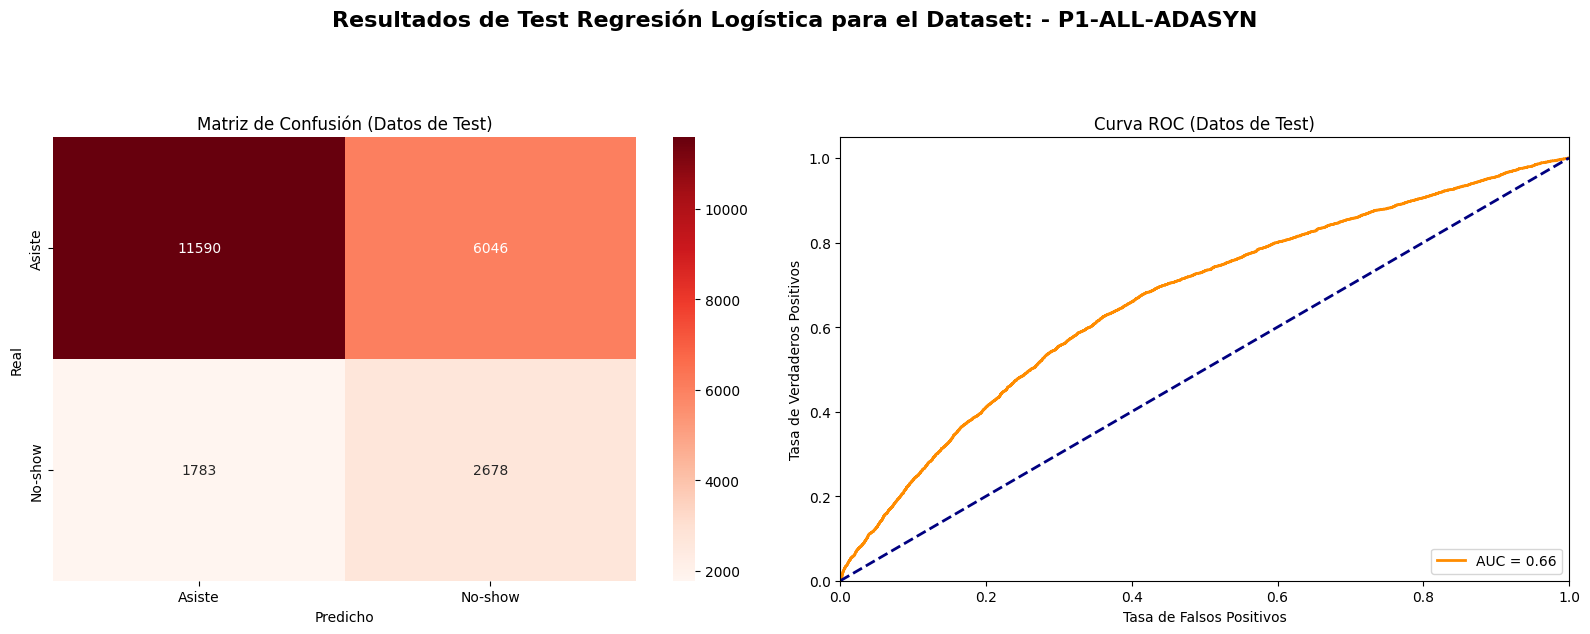

Modelo cargado exitosamente.
Mejores hiperparámetros cargados: {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 2}
..................................
Resultados datos de entrenamiento:
Accuracy (Datos de Train): 0.8052499601397284
Precision (Datos de Train): 0.7664980621428102
Recall (Datos de Train): 0.8650820717367773
F1 Score (Datos de Train): 0.812811725041099
[[52768 17773]
 [ 9099 58342]]


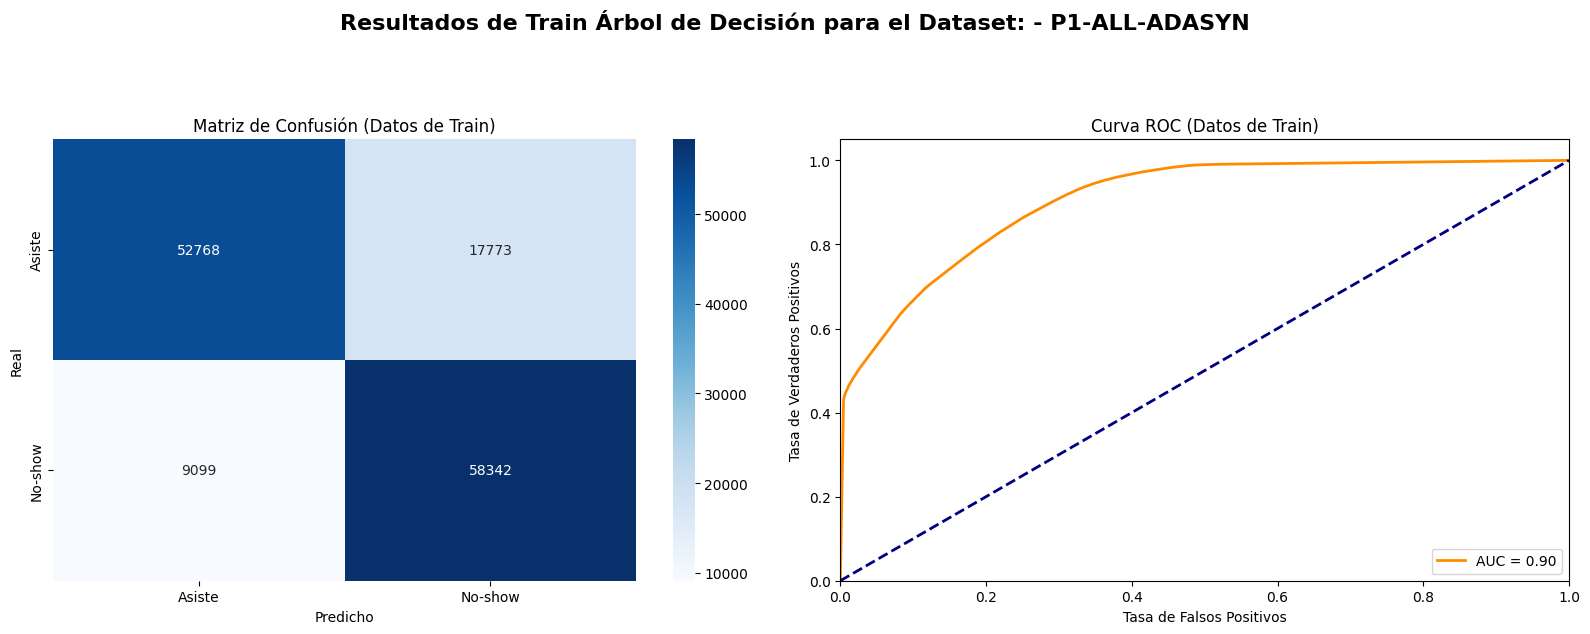

.........................
Resultados datos de test:
Accuracy (Datos de Test): 0.6504050323573336
Precision (Datos de Test): 0.28688952729172107
Recall (Datos de Test): 0.49249047298811927
F1 Score (Datos de Test): 0.362571169238386
[[12175  5461]
 [ 2264  2197]]


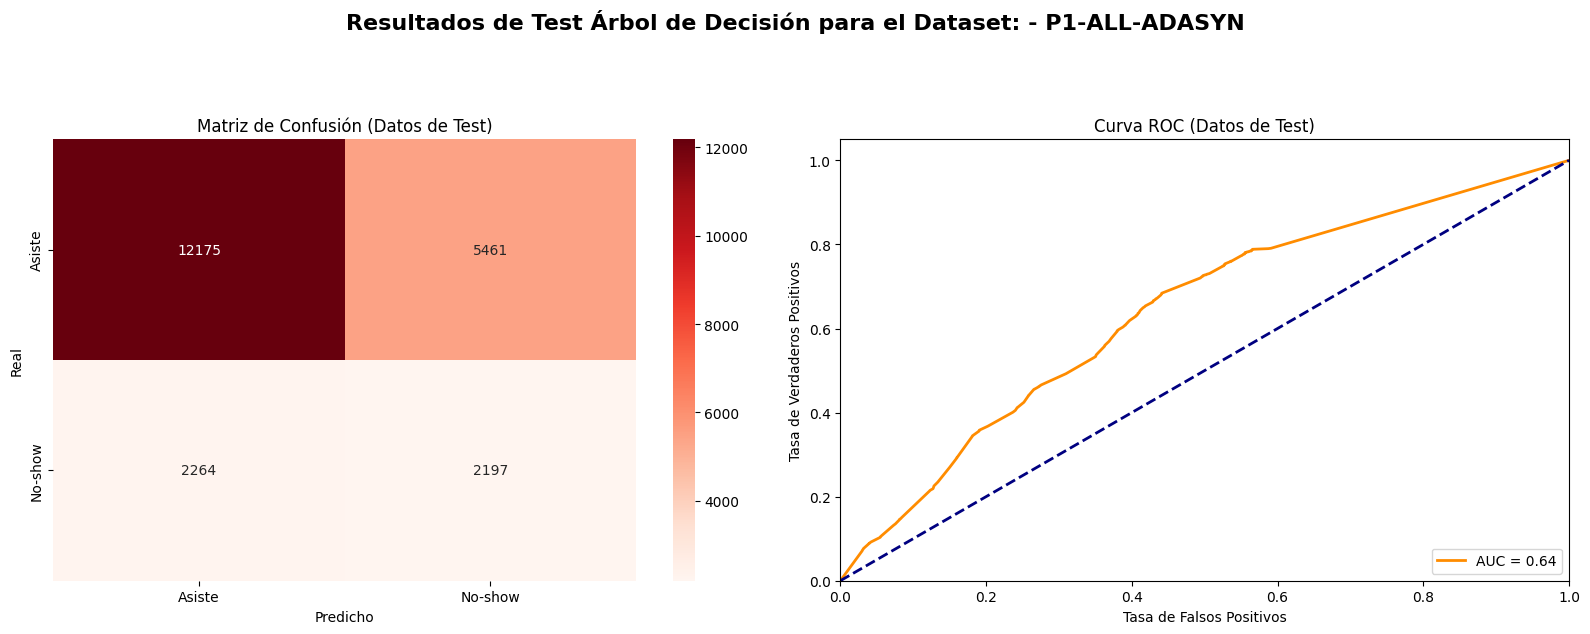

Modelo cargado exitosamente.
..................................
Resultados datos de entrenamiento:
Accuracy (Datos de Train): 0.6828571842704121
Precision (Datos de Train): 0.6316708368084515
Recall (Datos de Train): 0.8422621254133242
F1 Score (Datos de Train): 0.7219221432838098
[[37419 33122]
 [10638 56803]]


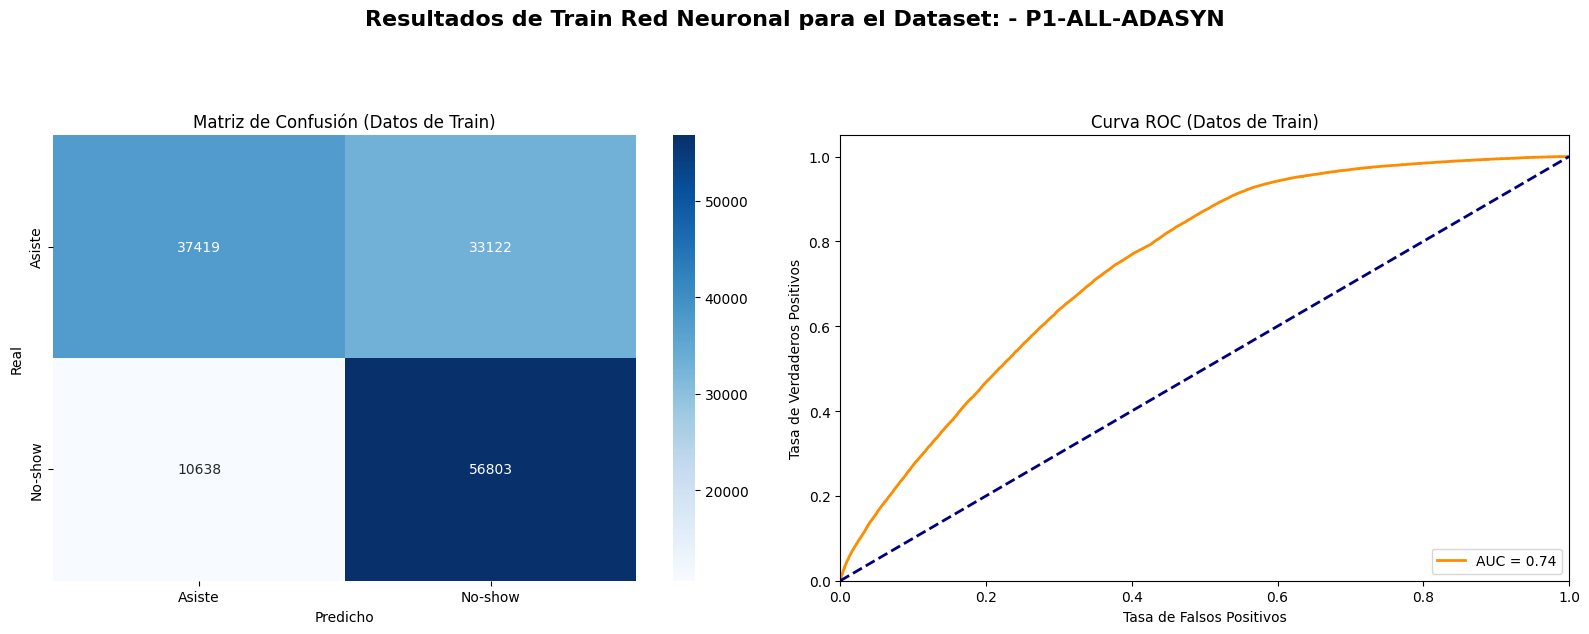

.........................
Resultados datos de test:
Accuracy (Datos de Test): 0.5345522016563334
Precision (Datos de Test): 0.2795943082046624
Recall (Datos de Test): 0.8280654561757453
F1 Score (Datos de Test): 0.41803881627341144
[[8118 9518]
 [ 767 3694]]


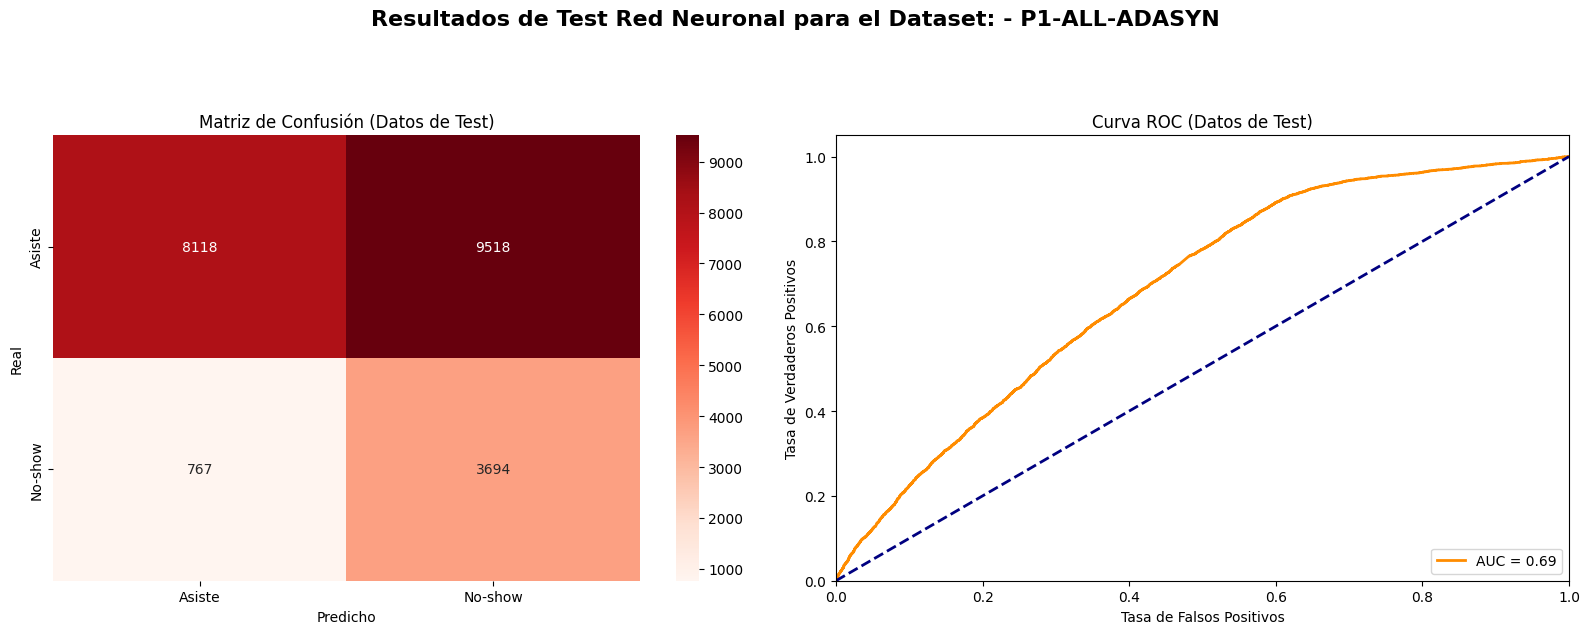

Modelo cargado exitosamente.
..................................
Resultados datos de entrenamiento:
Accuracy (Datos de Train): 0.6913293038222377
Precision (Datos de Train): 0.6325842456836759
Recall (Datos de Train): 0.8790201806023042
F1 Score (Datos de Train): 0.7357140640997797
[[36109 34432]
 [ 8159 59282]]


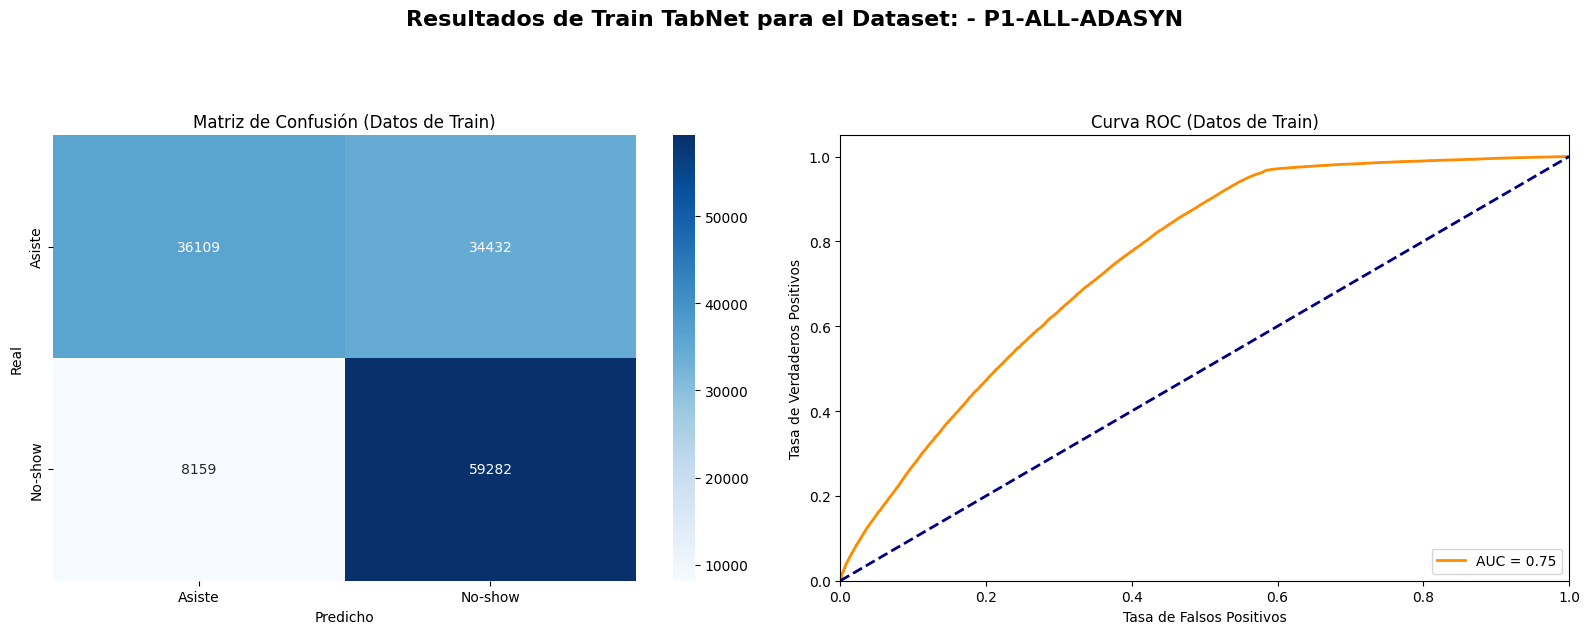

.........................
Resultados datos de test:
Accuracy (Datos de Test): 0.588993981083405
Precision (Datos de Test): 0.3019288469781397
Recall (Datos de Test): 0.7895090786819099
F1 Score (Datos de Test): 0.4368101203026169
[[9493 8143]
 [ 939 3522]]


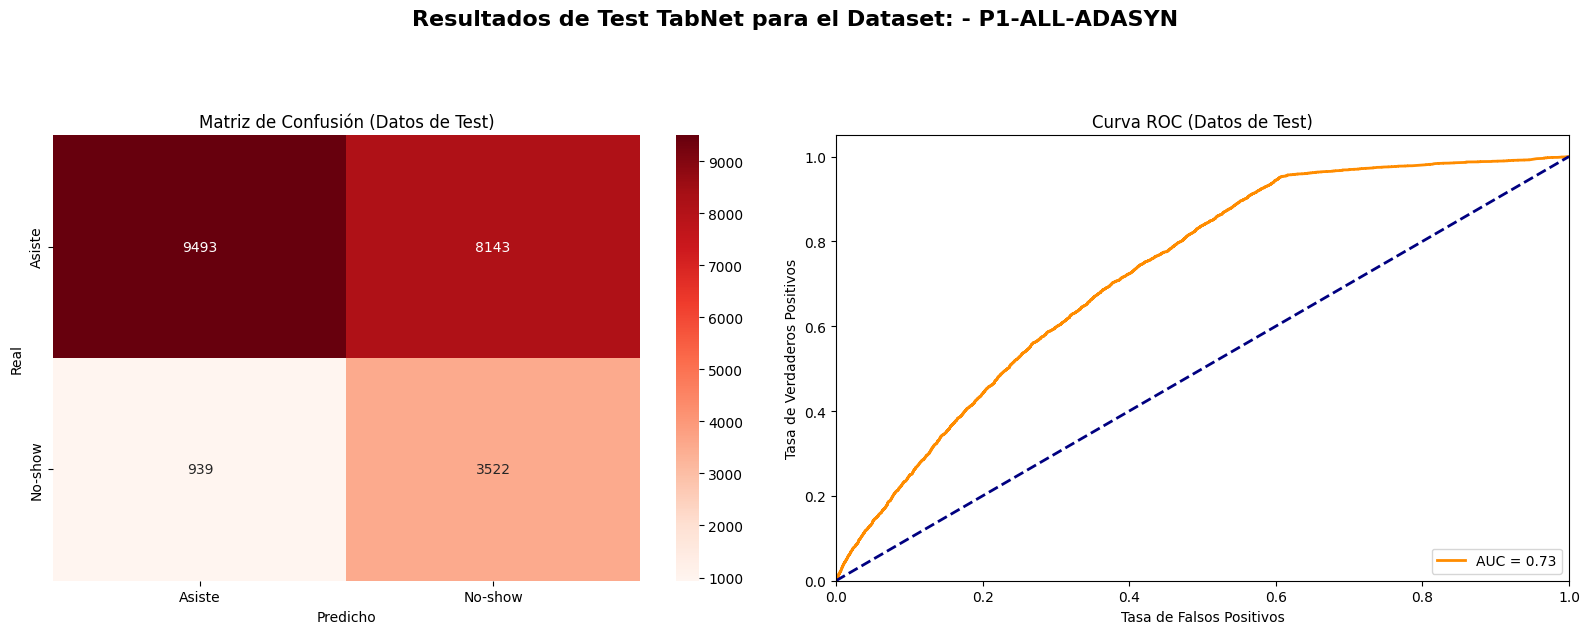


Ejecutando modelo para el dataset: P1-ALL

Modelo cargado exitosamente.
Mejores hiperparámetros cargados: {'C': 1, 'max_iter': 100, 'solver': 'newton-cg'}
..................................
Resultados datos de entrenamiento:
Accuracy (Datos de Train): 0.6390387560372246
Precision (Datos de Train): 0.6369383265481579
Recall (Datos de Train): 0.44351516005211816
F1 Score (Datos de Train): 0.5229134013556015
[[56183 14358]
 [31605 25189]]


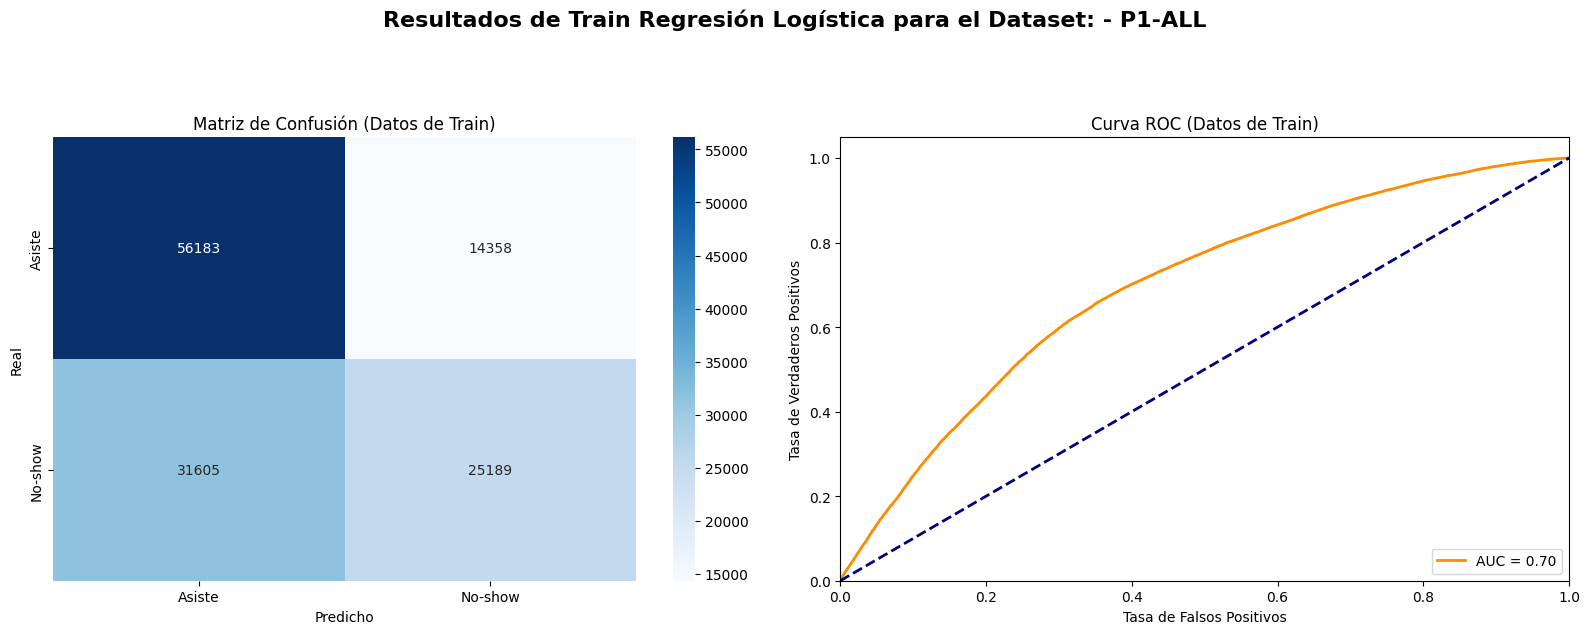

.........................
Resultados datos de test:
Accuracy (Datos de Test): 0.6772412544689325
Precision (Datos de Test): 0.32047318187928486
Recall (Datos de Test): 0.5344093252633939
F1 Score (Datos de Test): 0.400672268907563
[[12581  5055]
 [ 2077  2384]]


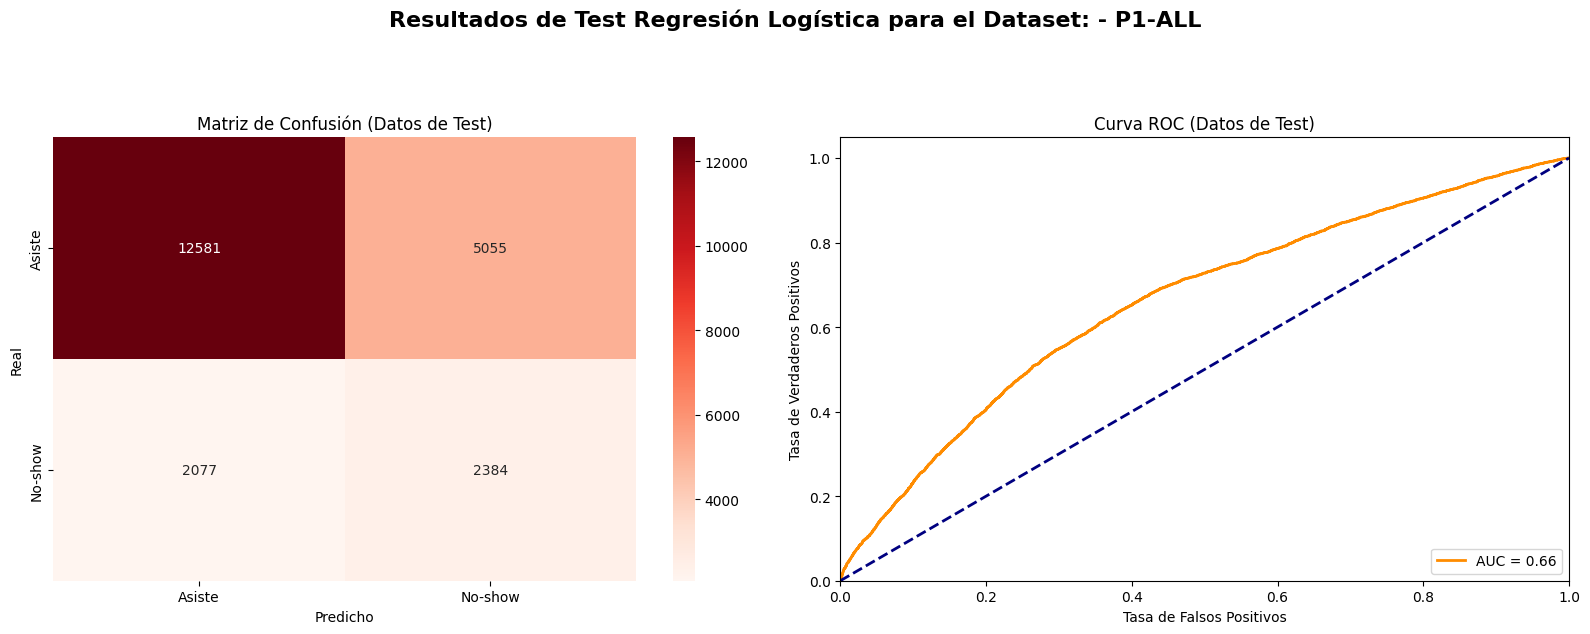

Modelo cargado exitosamente.
Mejores hiperparámetros cargados: {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2}
..................................
Resultados datos de entrenamiento:
Accuracy (Datos de Train): 0.8486826088663761
Precision (Datos de Train): 0.8266425263744298
Recall (Datos de Train): 0.8360742331936473
F1 Score (Datos de Train): 0.8313316292587275
[[60583  9958]
 [ 9310 47484]]


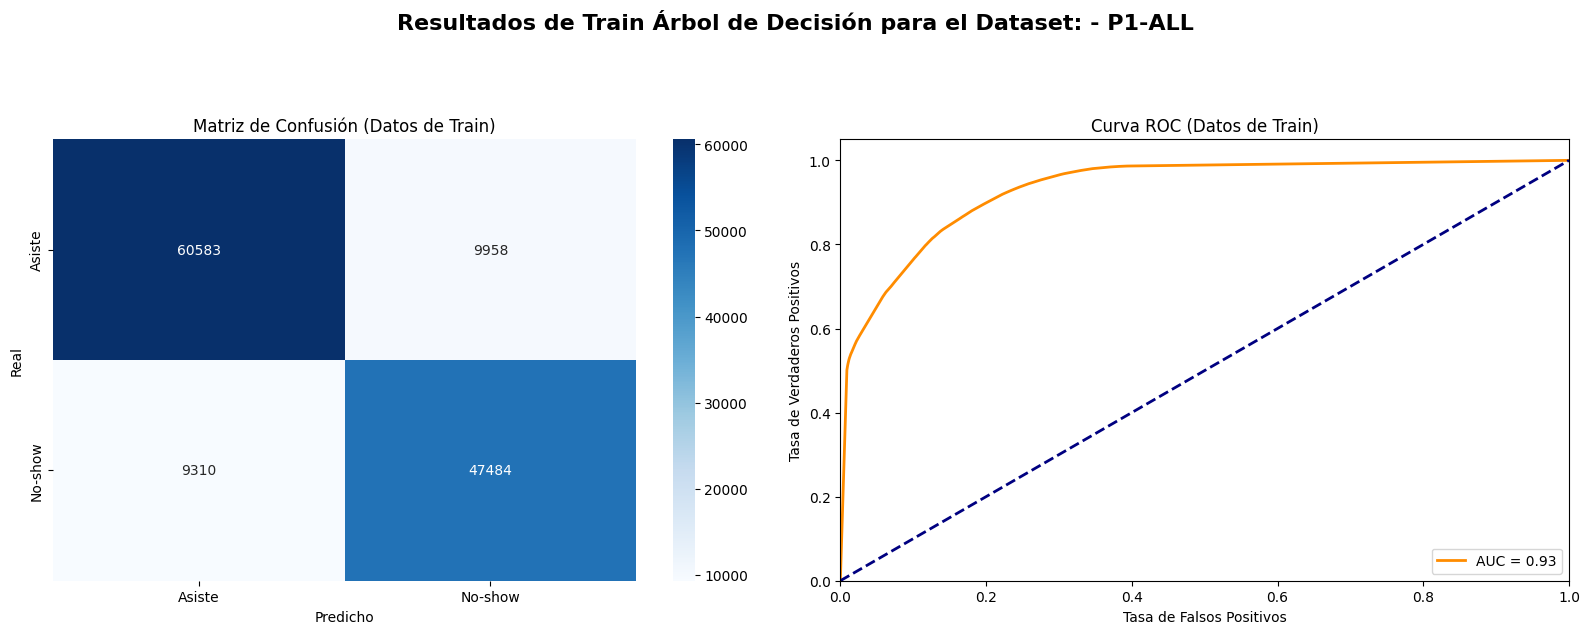

.........................
Resultados datos de test:
Accuracy (Datos de Test): 0.7104584332714848
Precision (Datos de Test): 0.31139240506329113
Recall (Datos de Test): 0.35843981170141226
F1 Score (Datos de Test): 0.33326385994164237
[[14100  3536]
 [ 2862  1599]]


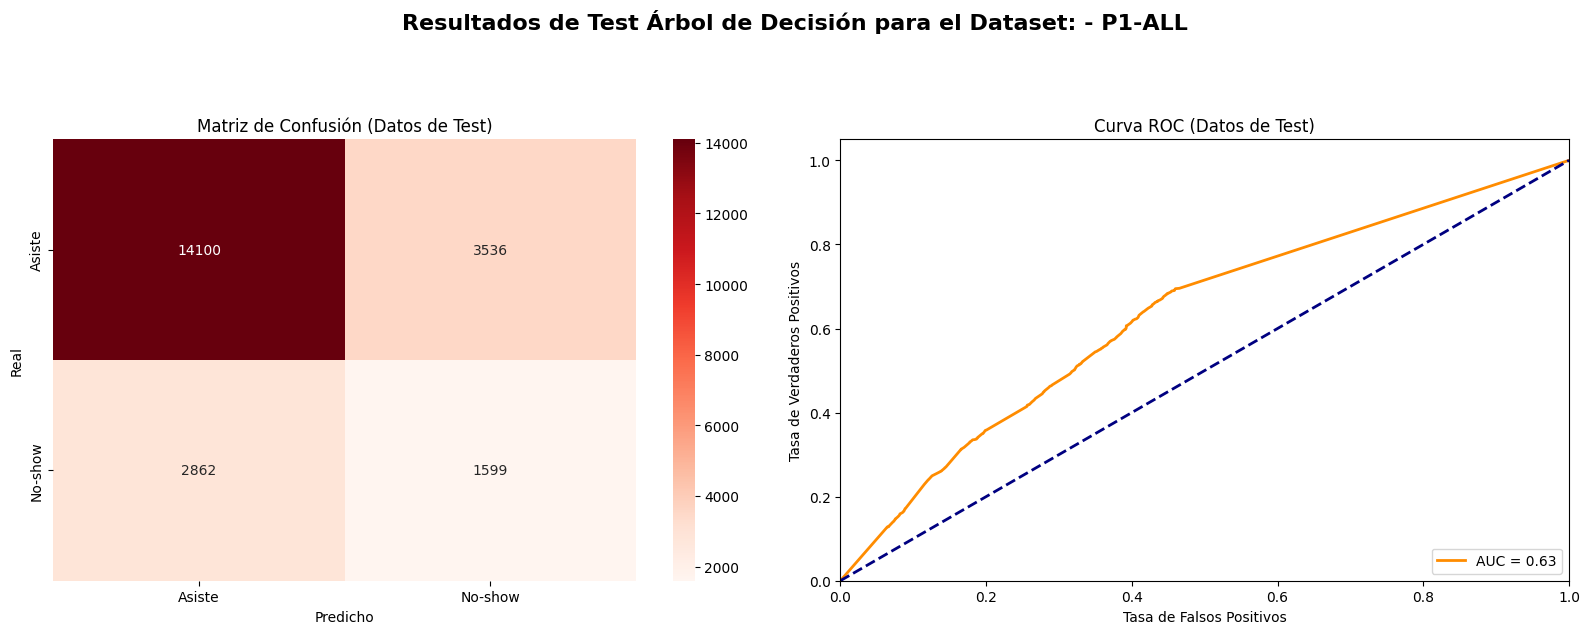

Modelo cargado exitosamente.
..................................
Resultados datos de entrenamiento:
Accuracy (Datos de Train): 0.7114304786586563
Precision (Datos de Train): 0.6489900866489307
Recall (Datos de Train): 0.7688488220586682
F1 Score (Datos de Train): 0.7038532524158385
[[46924 23617]
 [13128 43666]]


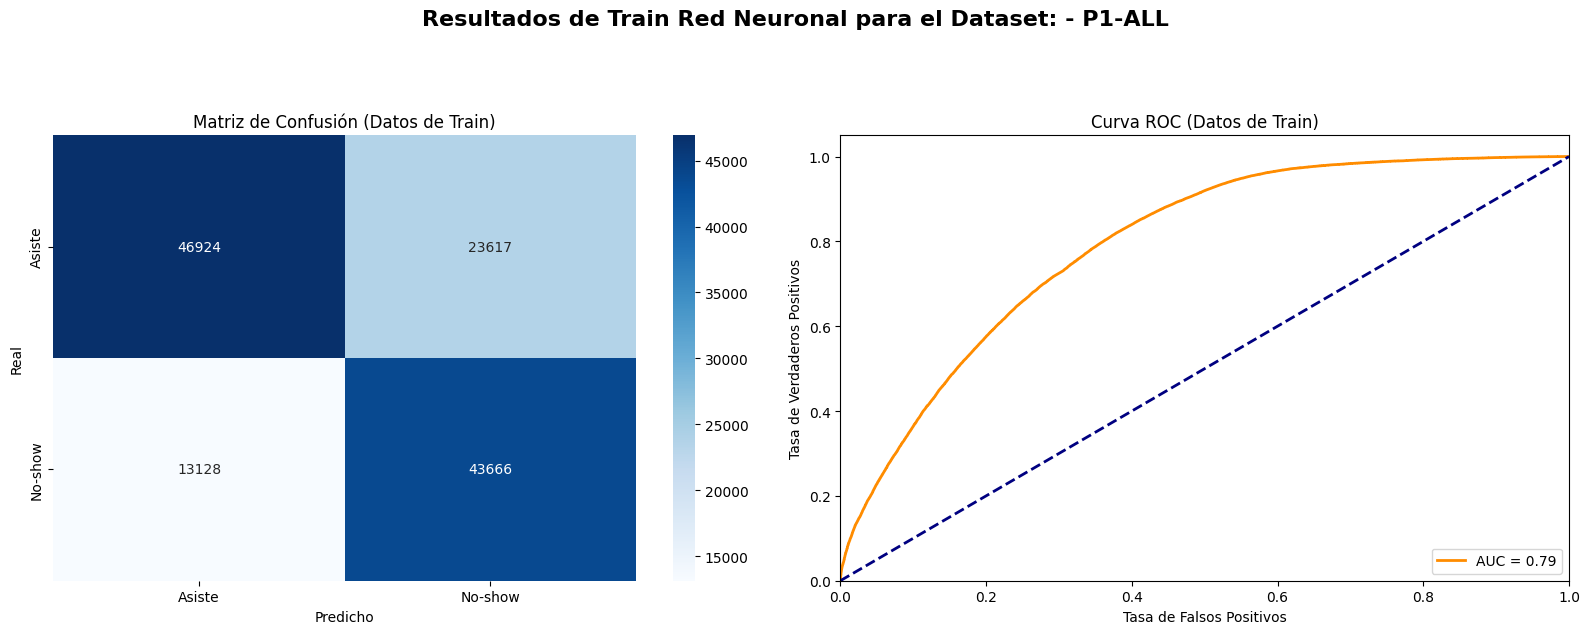

.........................
Resultados datos de test:
Accuracy (Datos de Test): 0.595646467846314
Precision (Datos de Test): 0.2884433516171742
Recall (Datos de Test): 0.6837032055592916
F1 Score (Datos de Test): 0.40571998669770537
[[10112  7524]
 [ 1411  3050]]


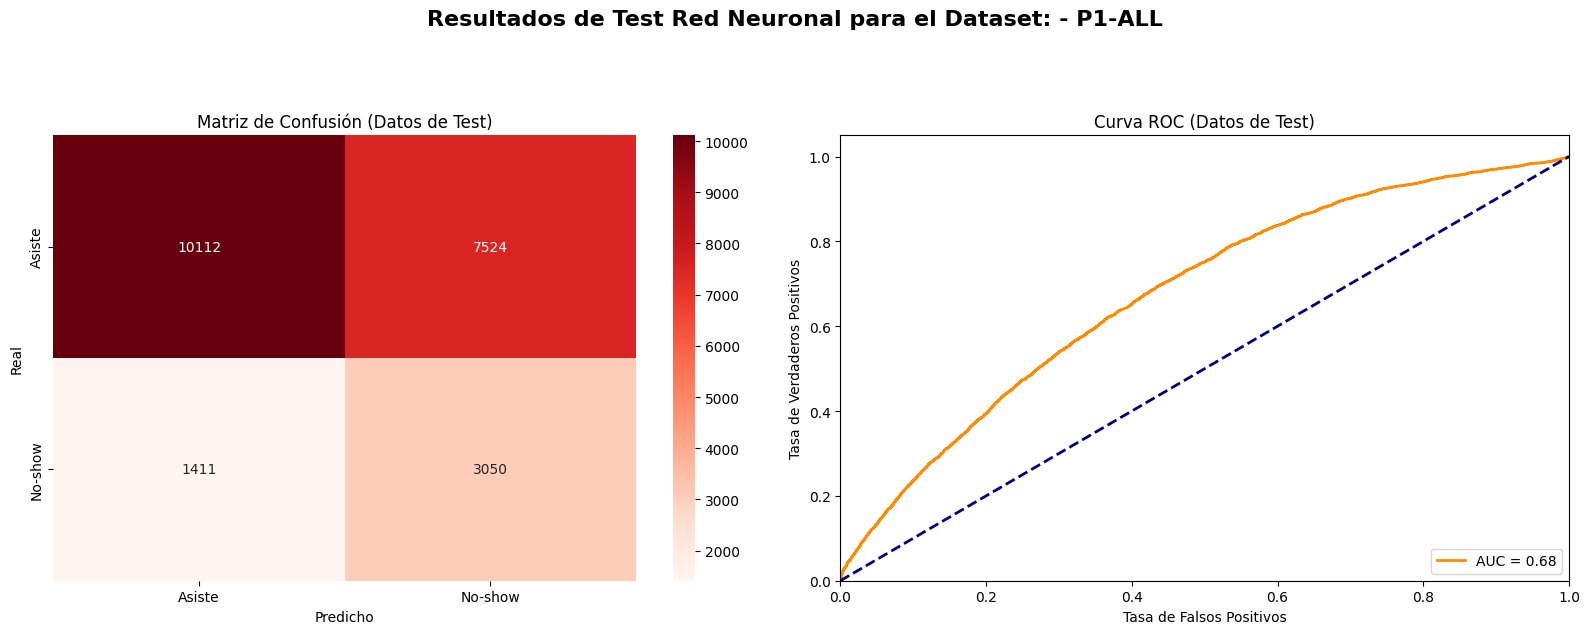

Modelo cargado exitosamente.
..................................
Resultados datos de entrenamiento:
Accuracy (Datos de Train): 0.6896140102878234
Precision (Datos de Train): 0.6138782292202397
Recall (Datos de Train): 0.8196464415255132
F1 Score (Datos de Train): 0.7019943449575872
[[41261 29280]
 [10243 46551]]


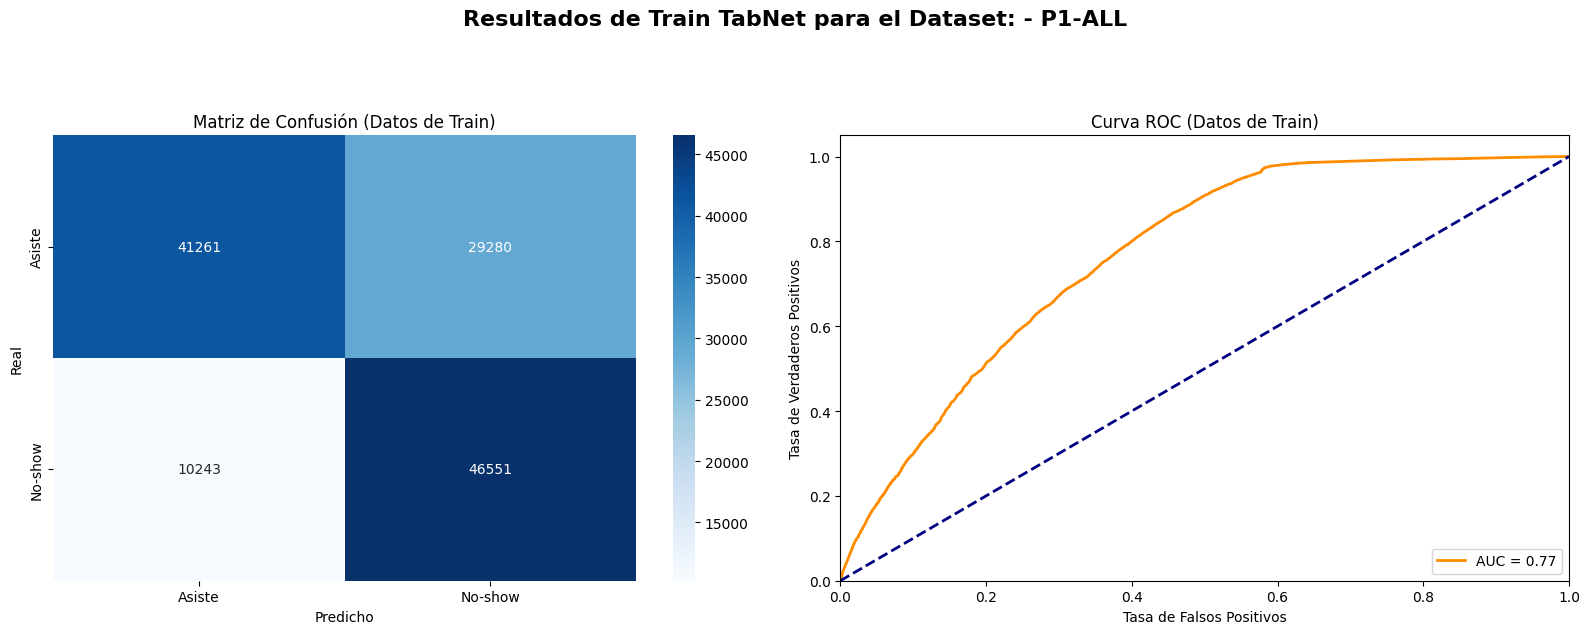

.........................
Resultados datos de test:
Accuracy (Datos de Test): 0.5795809385889488
Precision (Datos de Test): 0.2980005019660336
Recall (Datos de Test): 0.7984756780990809
F1 Score (Datos de Test): 0.4340197392469843
[[9245 8391]
 [ 899 3562]]


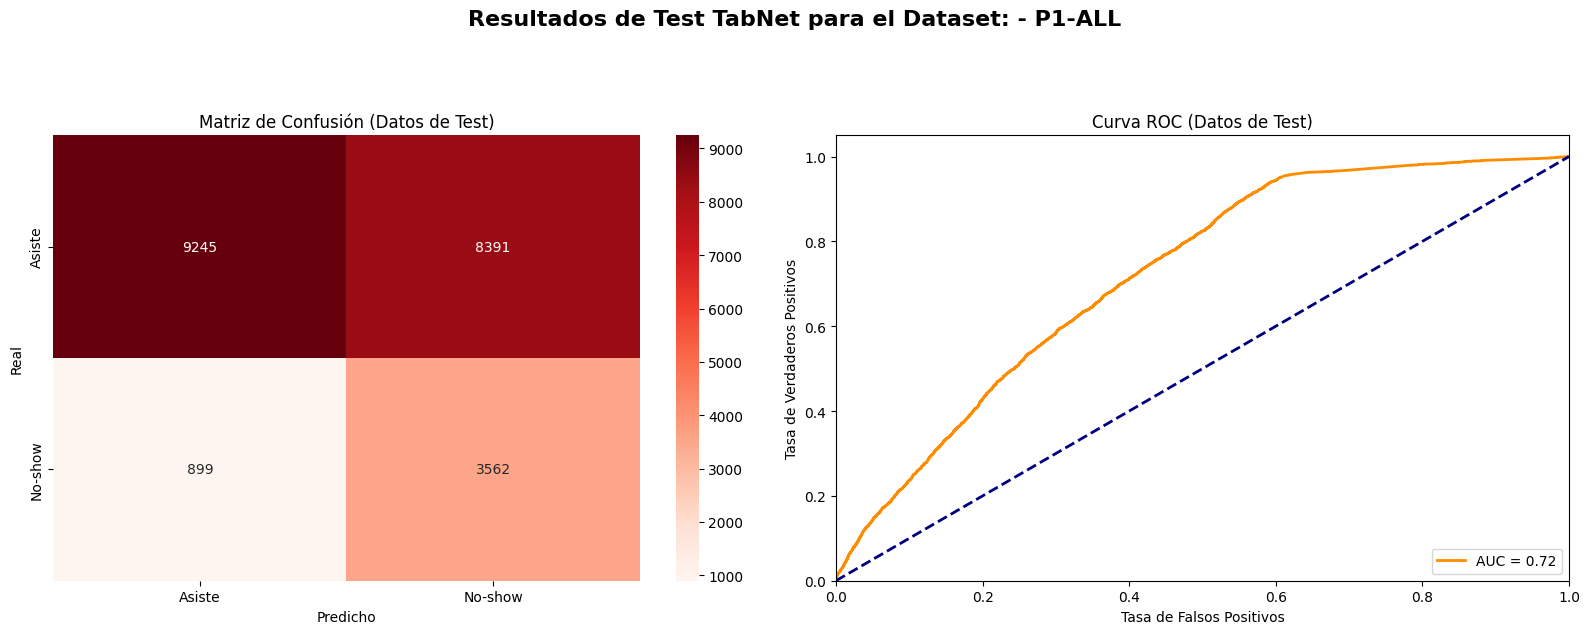


Ejecutando modelo para el dataset: P2-NOCONDITIONS

Modelo cargado exitosamente.
Mejores hiperparámetros cargados: {'C': 10, 'max_iter': 200, 'solver': 'sag'}
..................................
Resultados datos de entrenamiento:
Accuracy (Datos de Train): 0.639138372434633
Precision (Datos de Train): 0.6317893010862882
Recall (Datos de Train): 0.43921726946733475
F1 Score (Datos de Train): 0.5181906056063769
[[42420 10779]
 [23614 18495]]


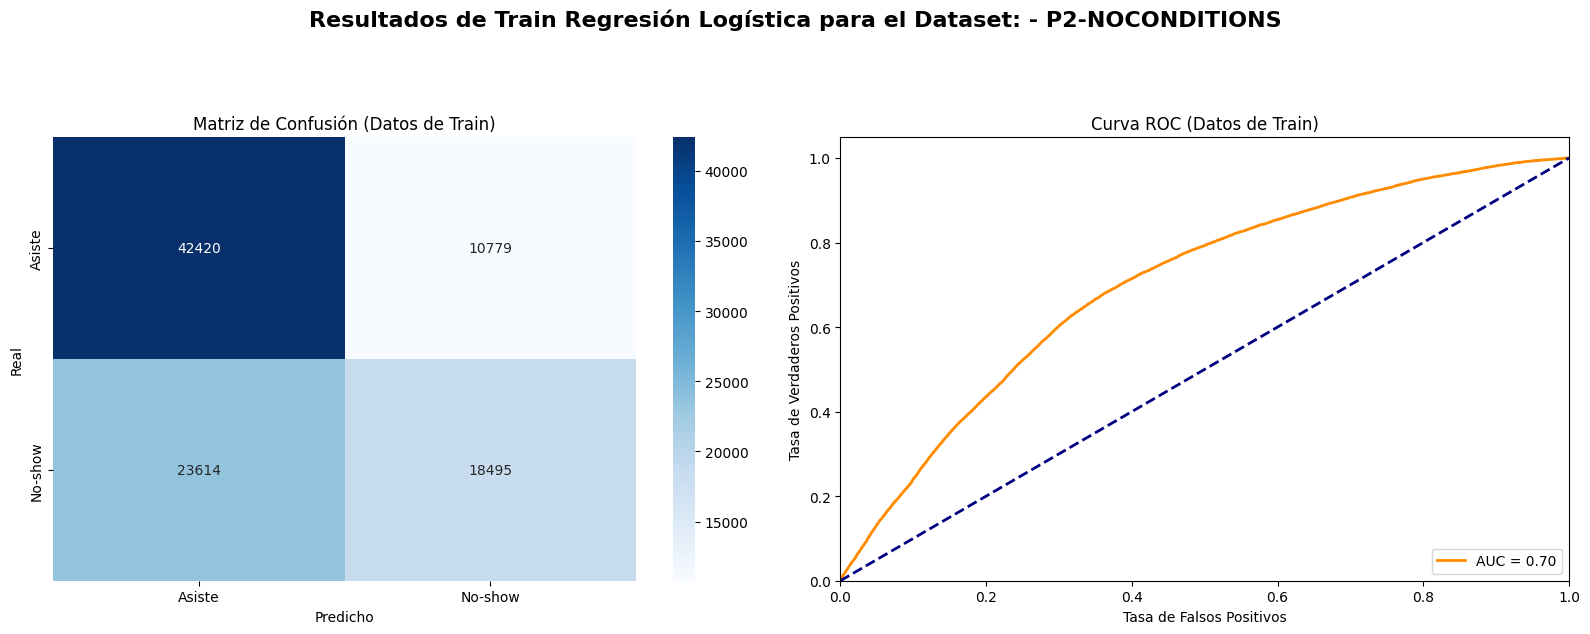

.........................
Resultados datos de test:
Accuracy (Datos de Test): 0.6745347523633985
Precision (Datos de Test): 0.32744924977934686
Recall (Datos de Test): 0.5271383915885195
F1 Score (Datos de Test): 0.40396341463414637
[[9490 3810]
 [1664 1855]]


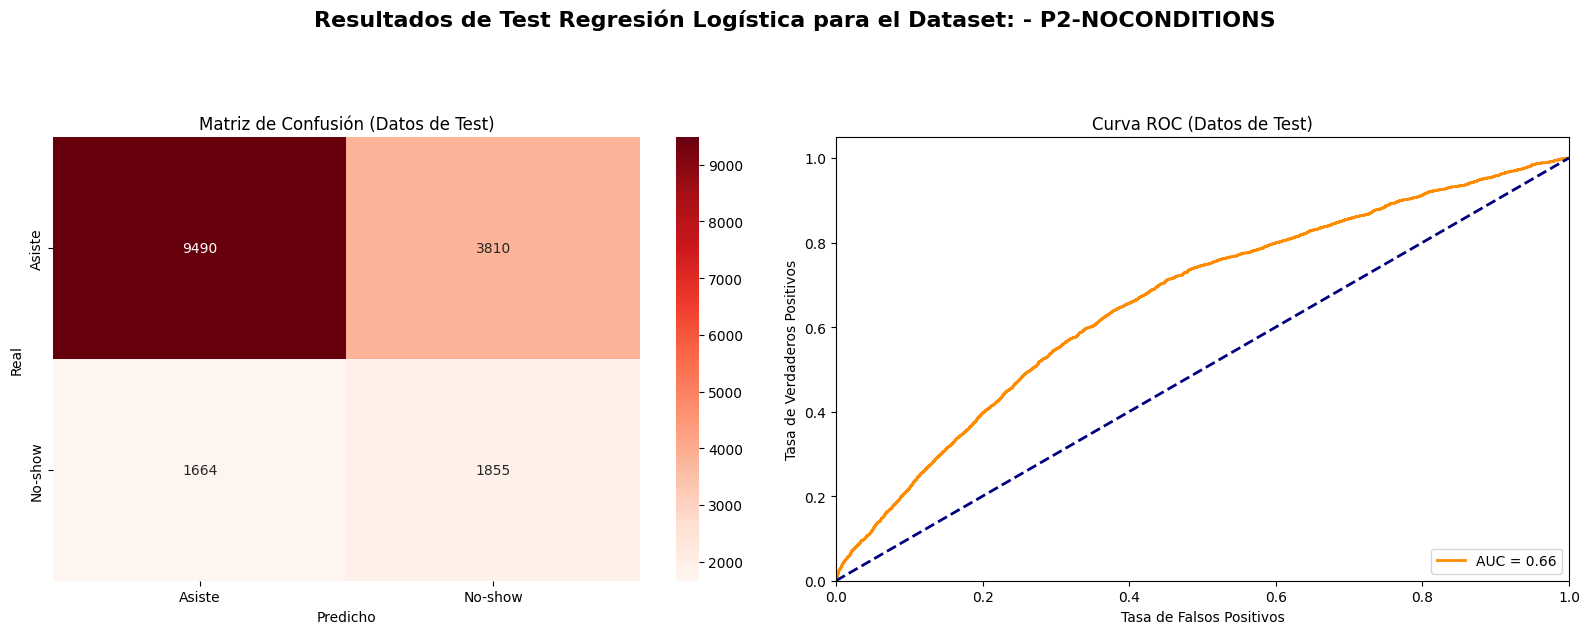

Modelo cargado exitosamente.
Mejores hiperparámetros cargados: {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2}
..................................
Resultados datos de entrenamiento:
Accuracy (Datos de Train): 0.8364775254962857
Precision (Datos de Train): 0.8195046737978221
Recall (Datos de Train): 0.8078083070127526
F1 Score (Datos de Train): 0.8136144563904469
[[45707  7492]
 [ 8093 34016]]


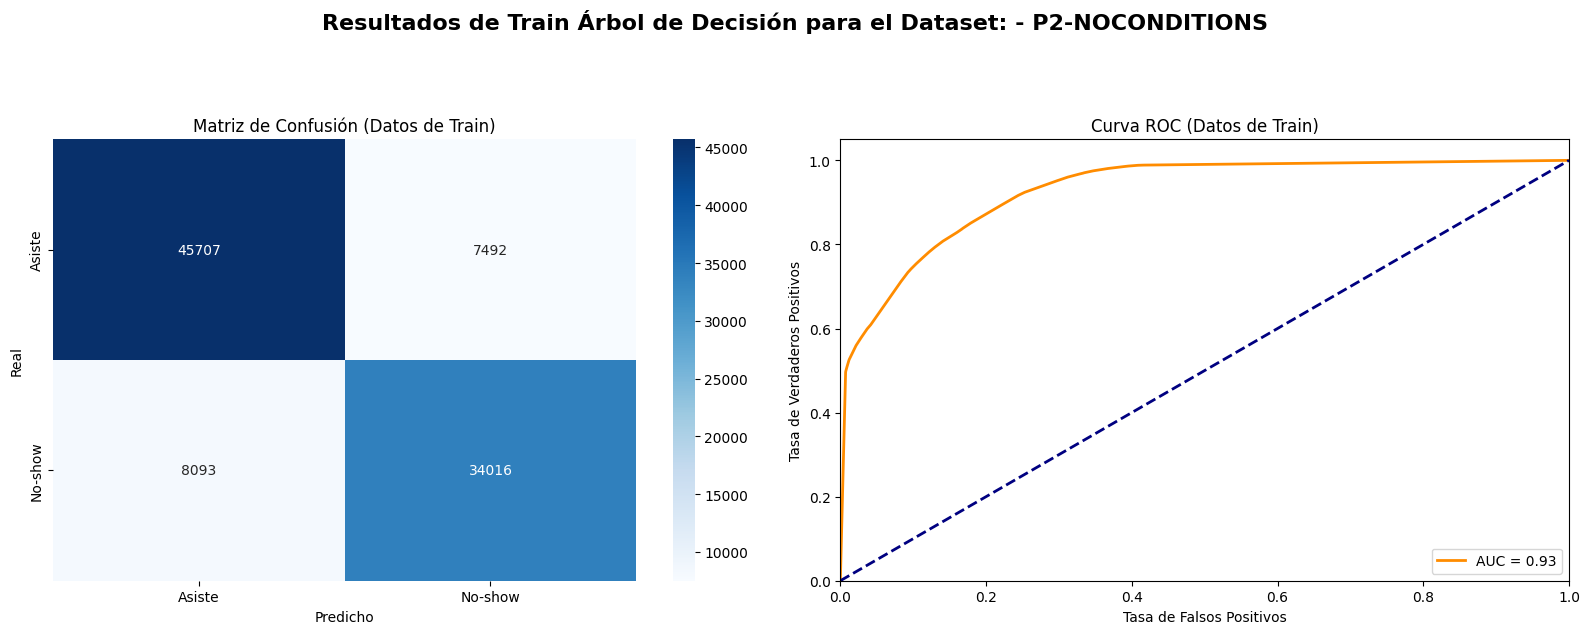

.........................
Resultados datos de test:
Accuracy (Datos de Test): 0.724656638325703
Precision (Datos de Test): 0.340870062965083
Recall (Datos de Test): 0.33844842284739984
F1 Score (Datos de Test): 0.33965492656495083
[[10997  2303]
 [ 2328  1191]]


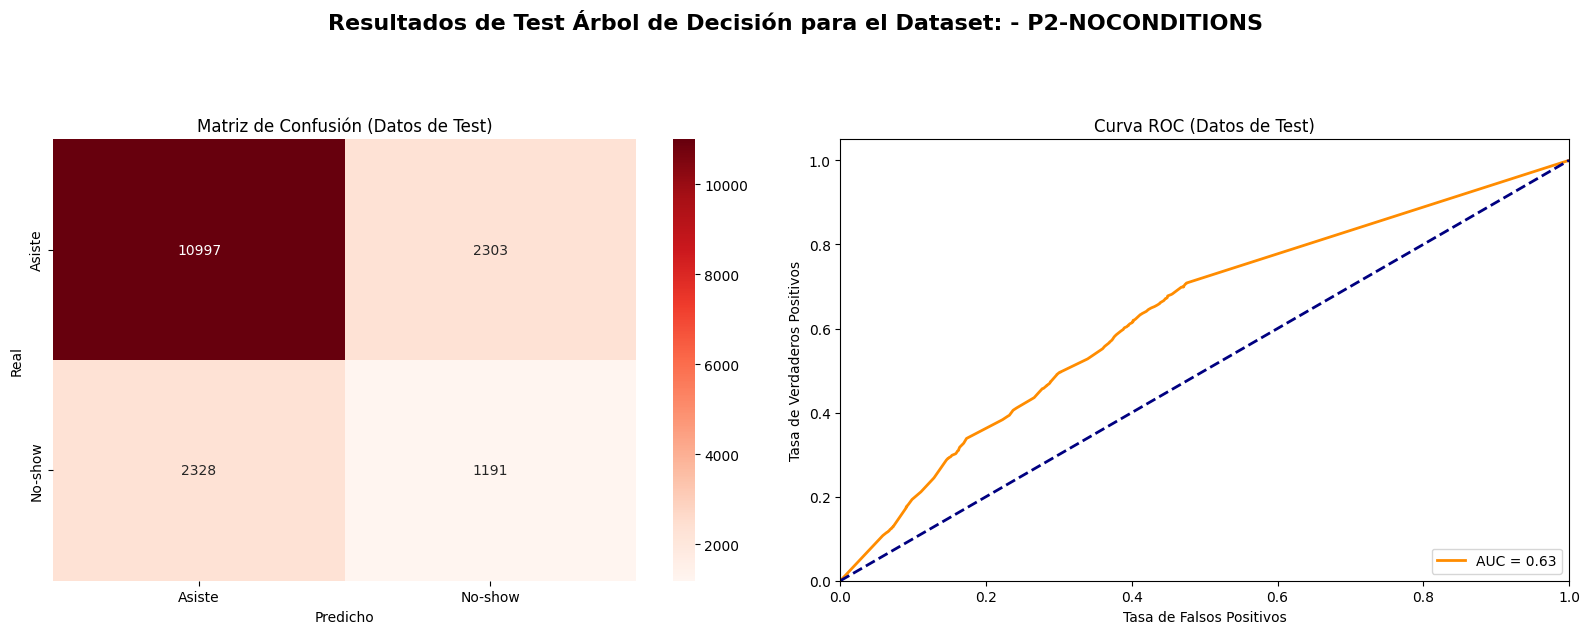

Modelo cargado exitosamente.
..................................
Resultados datos de entrenamiento:
Accuracy (Datos de Train): 0.7184811348470223
Precision (Datos de Train): 0.6579676578849415
Recall (Datos de Train): 0.7556104395734878
F1 Score (Datos de Train): 0.7034167154874154
[[36659 16540]
 [10291 31818]]


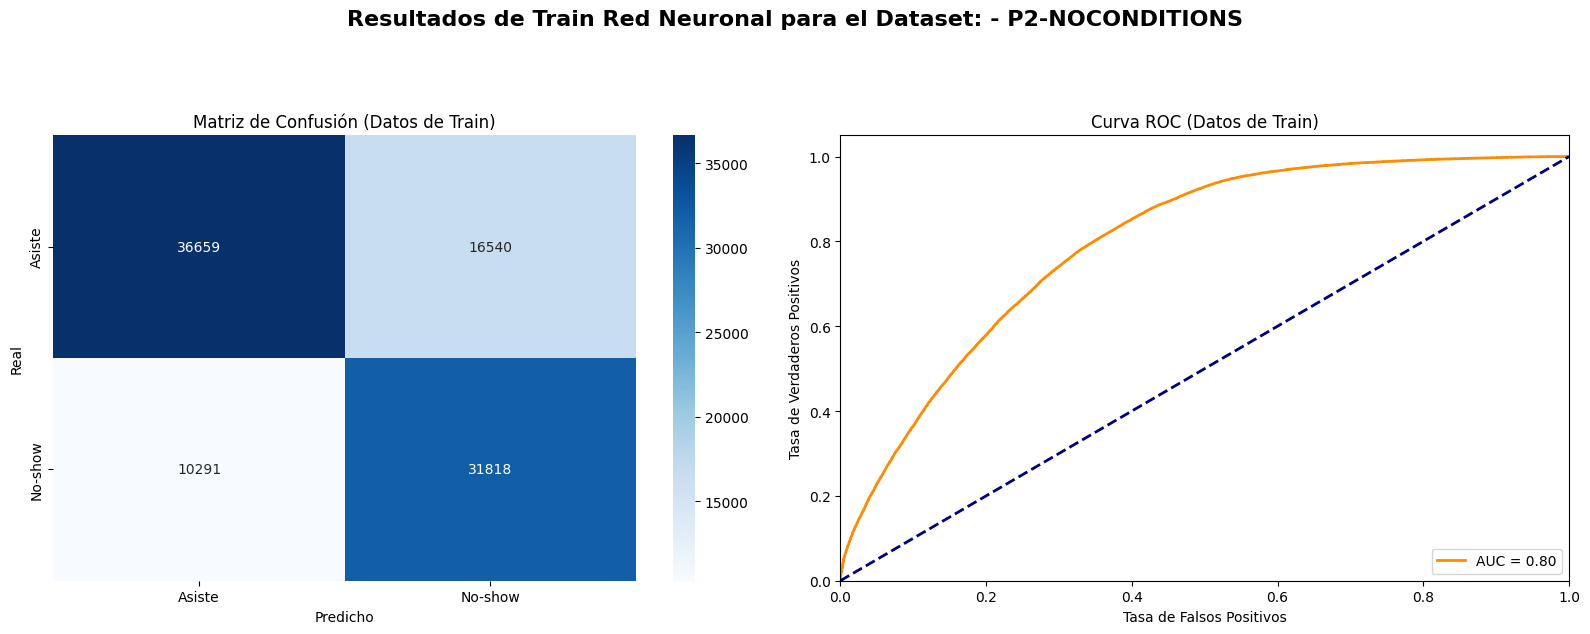

.........................
Resultados datos de test:
Accuracy (Datos de Test): 0.6182888400023783
Precision (Datos de Test): 0.3106644041247879
Recall (Datos de Test): 0.6763285024154589
F1 Score (Datos de Test): 0.4257602862254025
[[8019 5281]
 [1139 2380]]


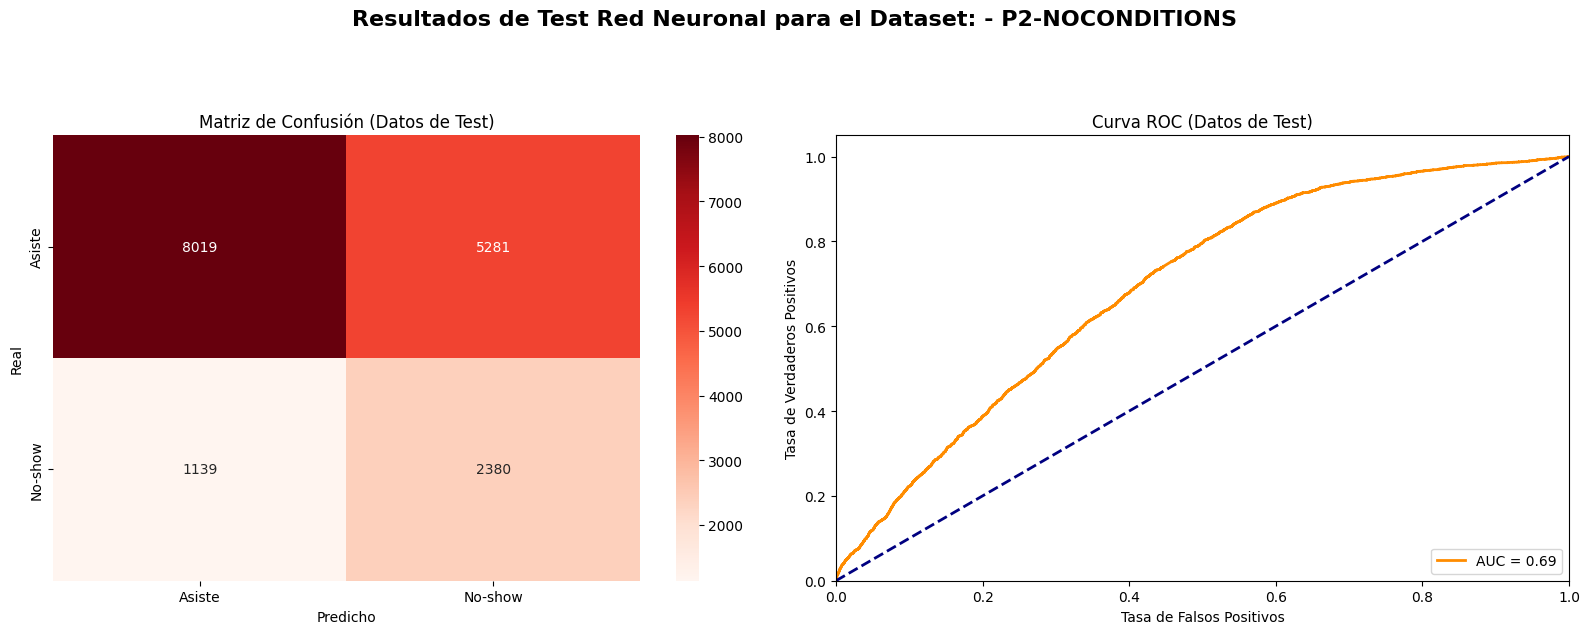

Modelo cargado exitosamente.
..................................
Resultados datos de entrenamiento:
Accuracy (Datos de Train): 0.7092059428379569
Precision (Datos de Train): 0.6389596848934198
Recall (Datos de Train): 0.7858890023510413
F1 Score (Datos de Train): 0.7048487236557651
[[34500 18699]
 [ 9016 33093]]


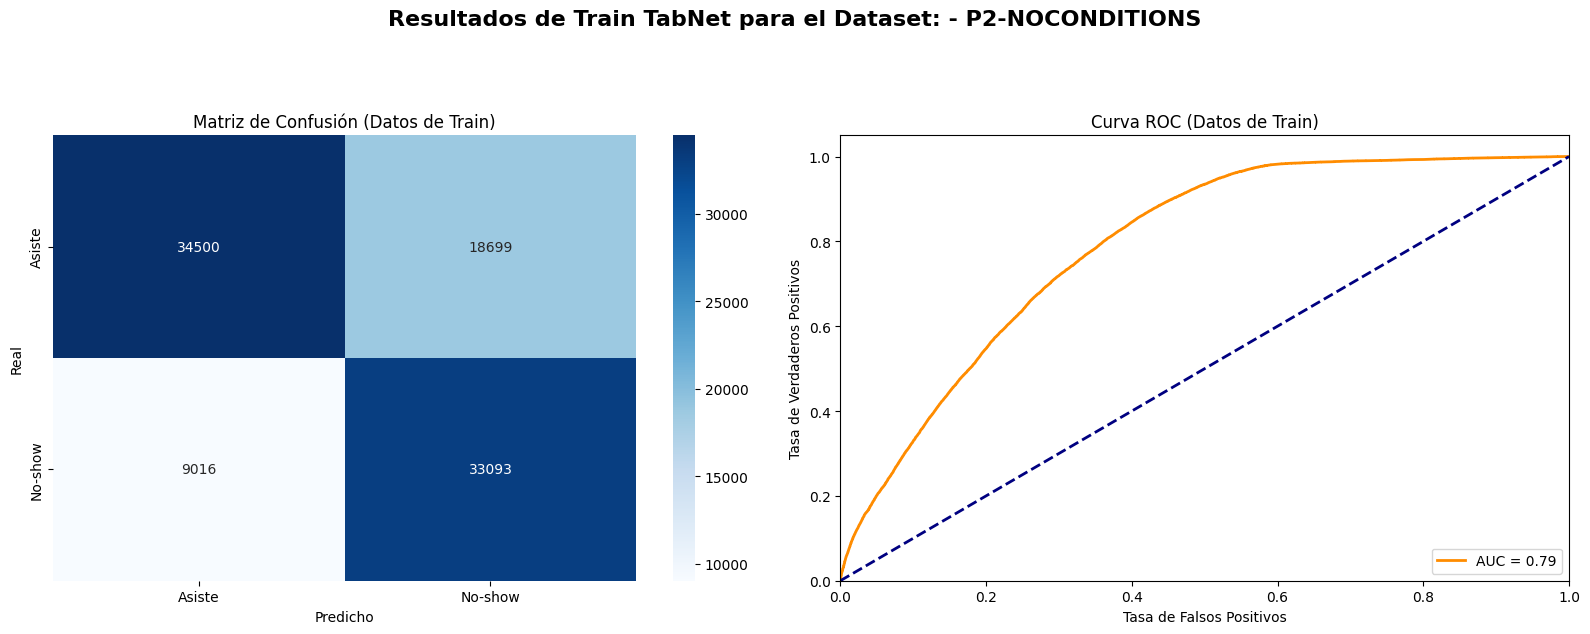

.........................
Resultados datos de test:
Accuracy (Datos de Test): 0.6414174445567513
Precision (Datos de Test): 0.32704489121454144
Recall (Datos de Test): 0.6749076442171071
F1 Score (Datos de Test): 0.4405899267229385
[[8413 4887]
 [1144 2375]]


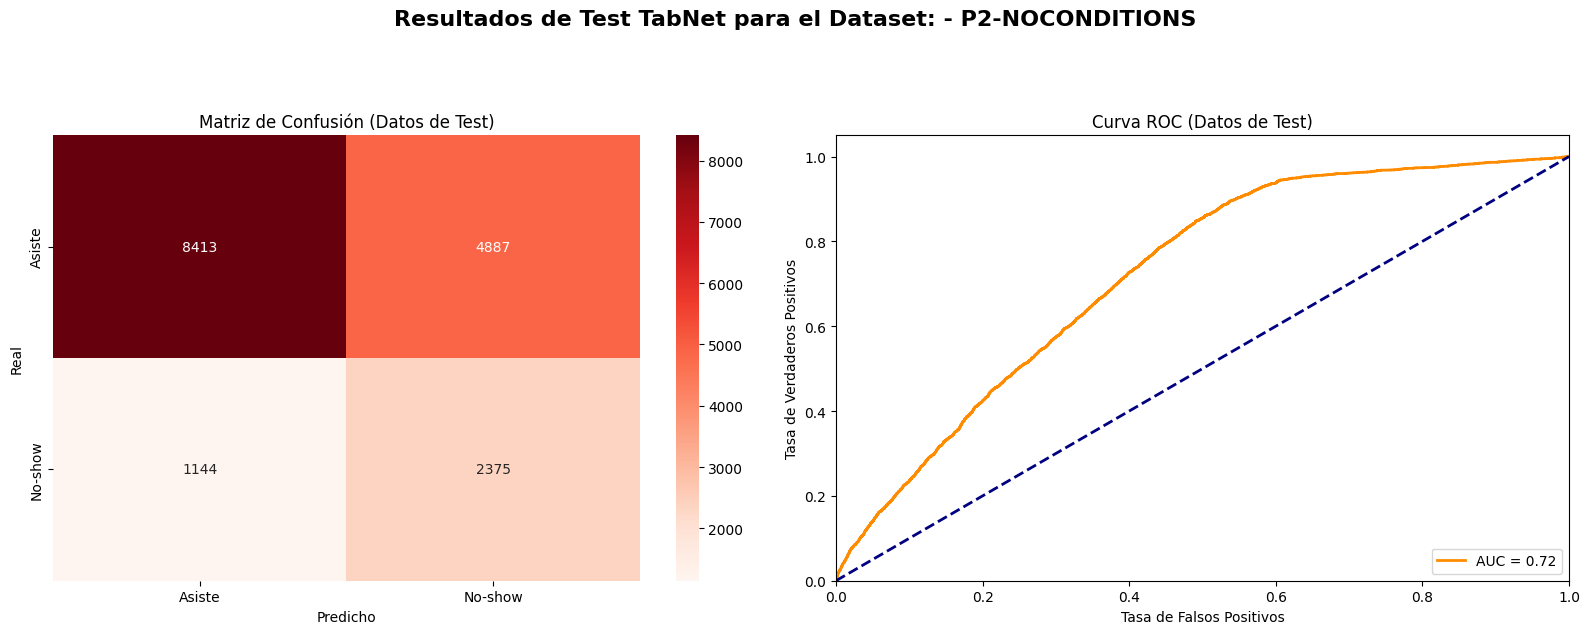


Ejecutando modelo para el dataset: P3-AGE

Modelo cargado exitosamente.
Mejores hiperparámetros cargados: {'C': 0.01, 'max_iter': 100, 'solver': 'liblinear'}
..................................
Resultados datos de entrenamiento:
Accuracy (Datos de Train): 0.6431497621731599
Precision (Datos de Train): 0.6313422094278518
Recall (Datos de Train): 0.4414114095226115
F1 Score (Datos de Train): 0.5195632056265038
[[16374  4098]
 [ 8881  7018]]


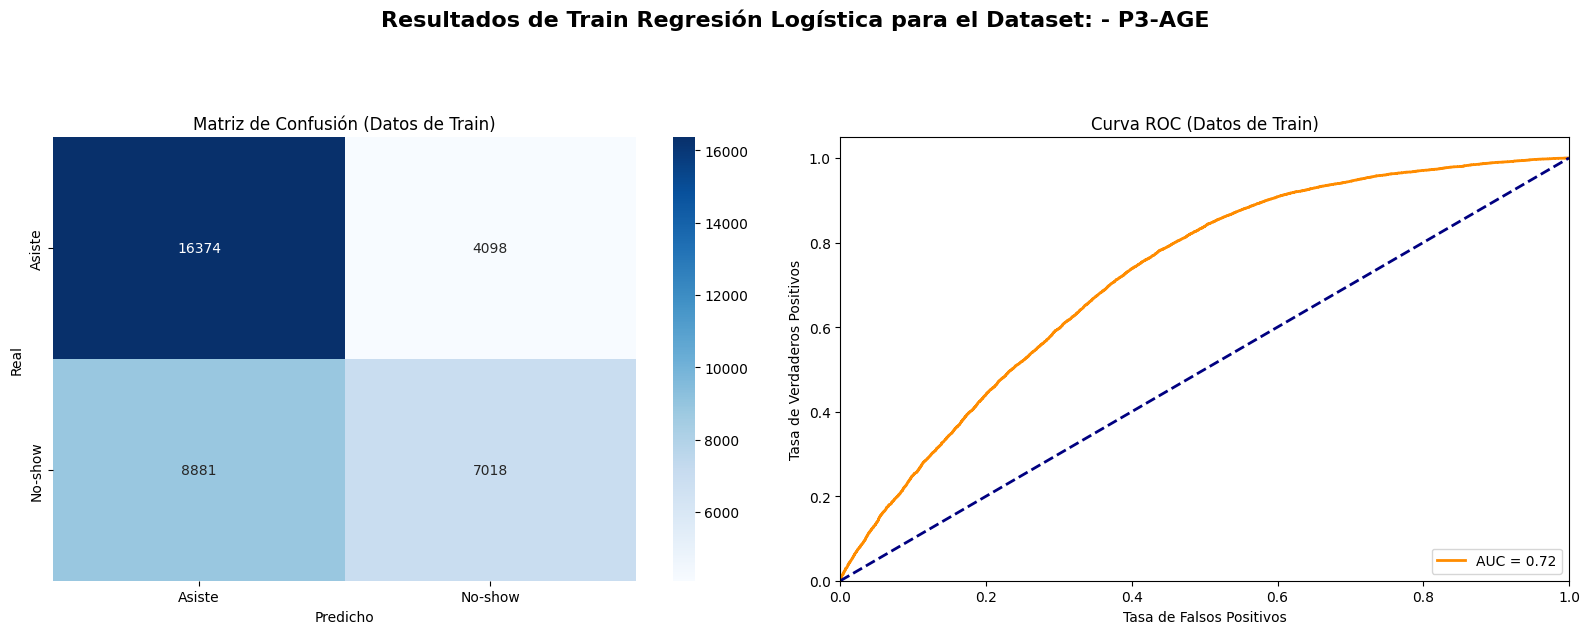

.........................
Resultados datos de test:
Accuracy (Datos de Test): 0.6893347101342381
Precision (Datos de Test): 0.39761248852157943
Recall (Datos de Test): 0.5216867469879518
F1 Score (Datos de Test): 0.4512767066180302
[[3807 1312]
 [ 794  866]]


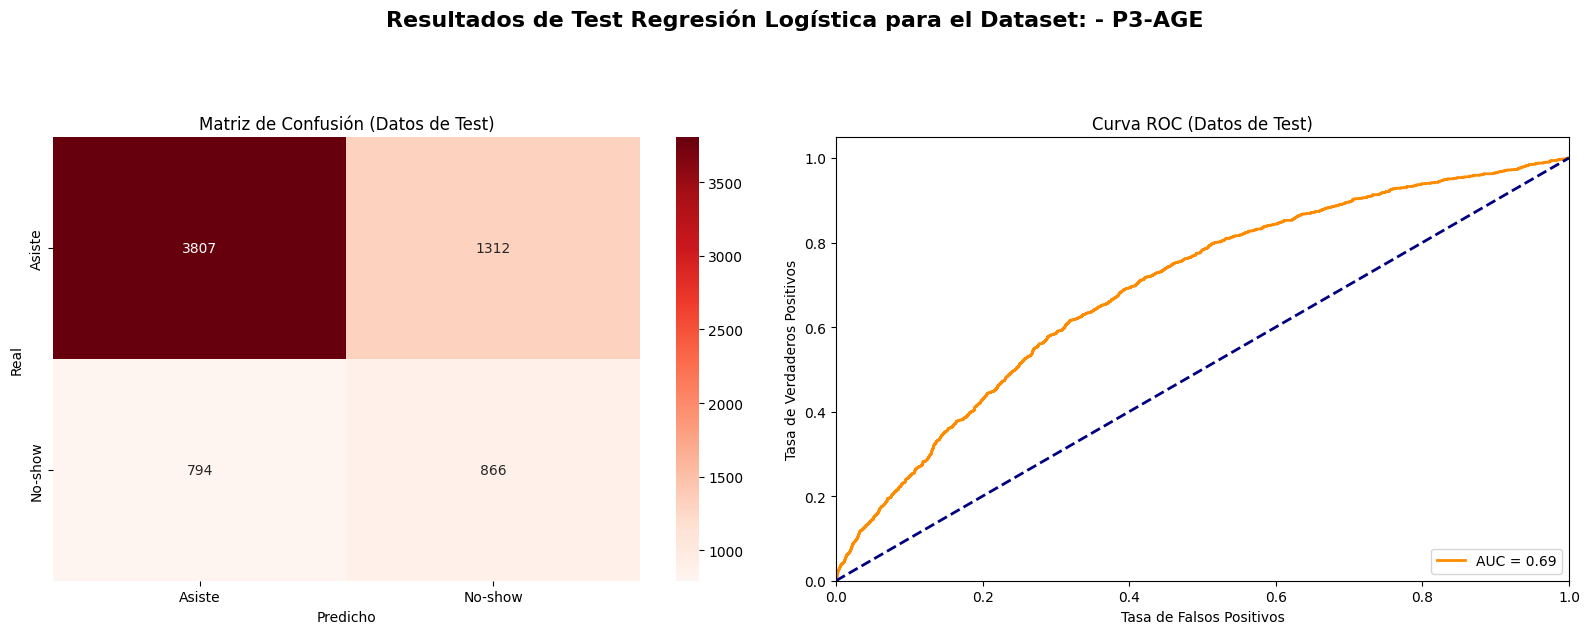

Modelo cargado exitosamente.
Mejores hiperparámetros cargados: {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2}
..................................
Resultados datos de entrenamiento:
Accuracy (Datos de Train): 0.8341535838992604
Precision (Datos de Train): 0.7706698853349426
Recall (Datos de Train): 0.8835146864582678
F1 Score (Datos de Train): 0.8232432749223466
[[16292  4180]
 [ 1852 14047]]


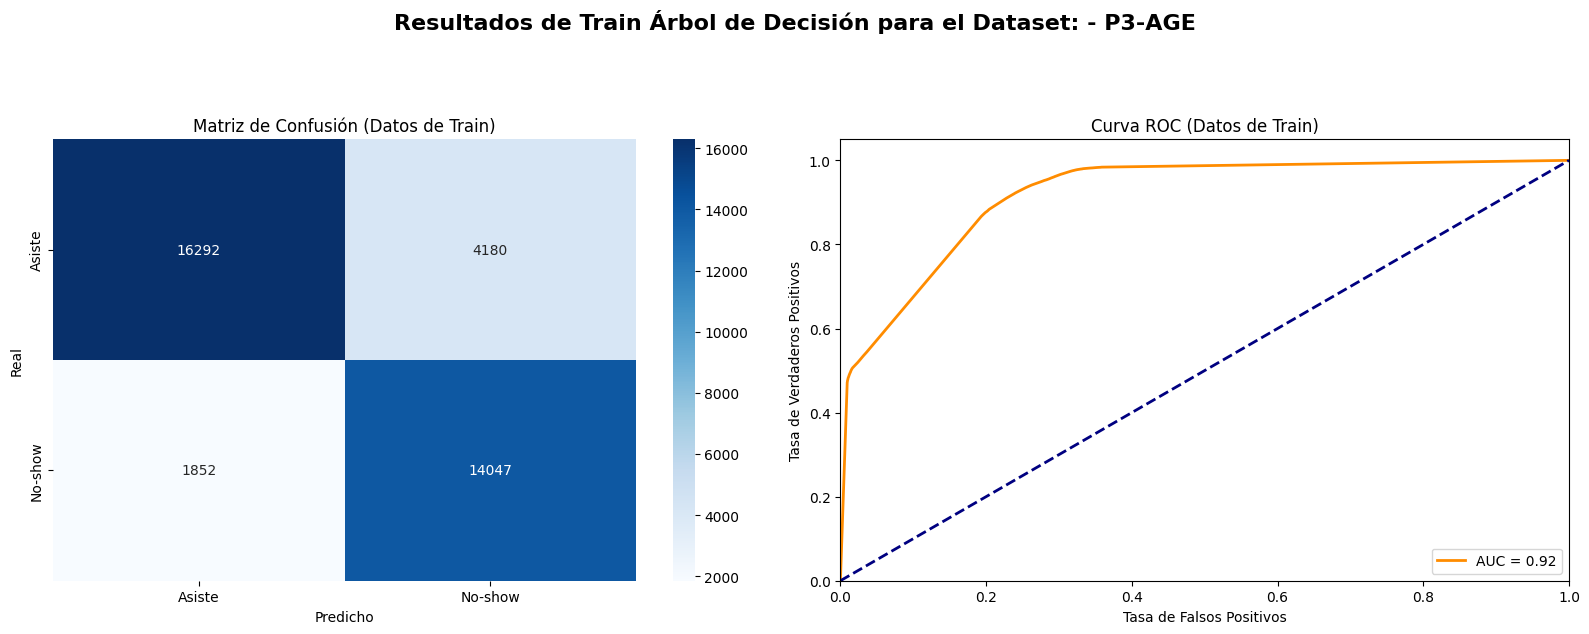

.........................
Resultados datos de test:
Accuracy (Datos de Test): 0.6915474258740227
Precision (Datos de Test): 0.38100496963003866
Recall (Datos de Test): 0.41566265060240964
F1 Score (Datos de Test): 0.3975799481417459
[[3998 1121]
 [ 970  690]]


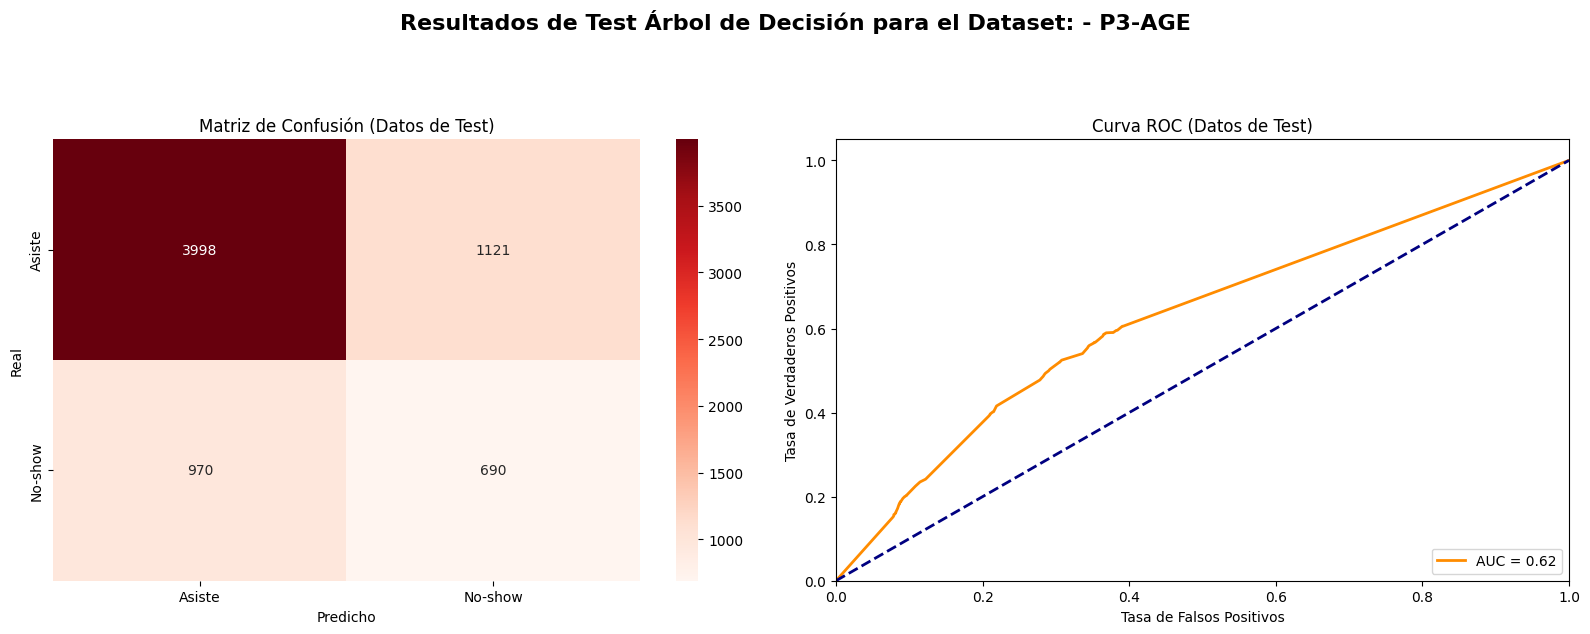

Modelo cargado exitosamente.
..................................
Resultados datos de entrenamiento:
Accuracy (Datos de Train): 0.718594484616865
Precision (Datos de Train): 0.6451117032178725
Recall (Datos de Train): 0.7918737027486006
F1 Score (Datos de Train): 0.7109981646195115
[[13546  6926]
 [ 3309 12590]]


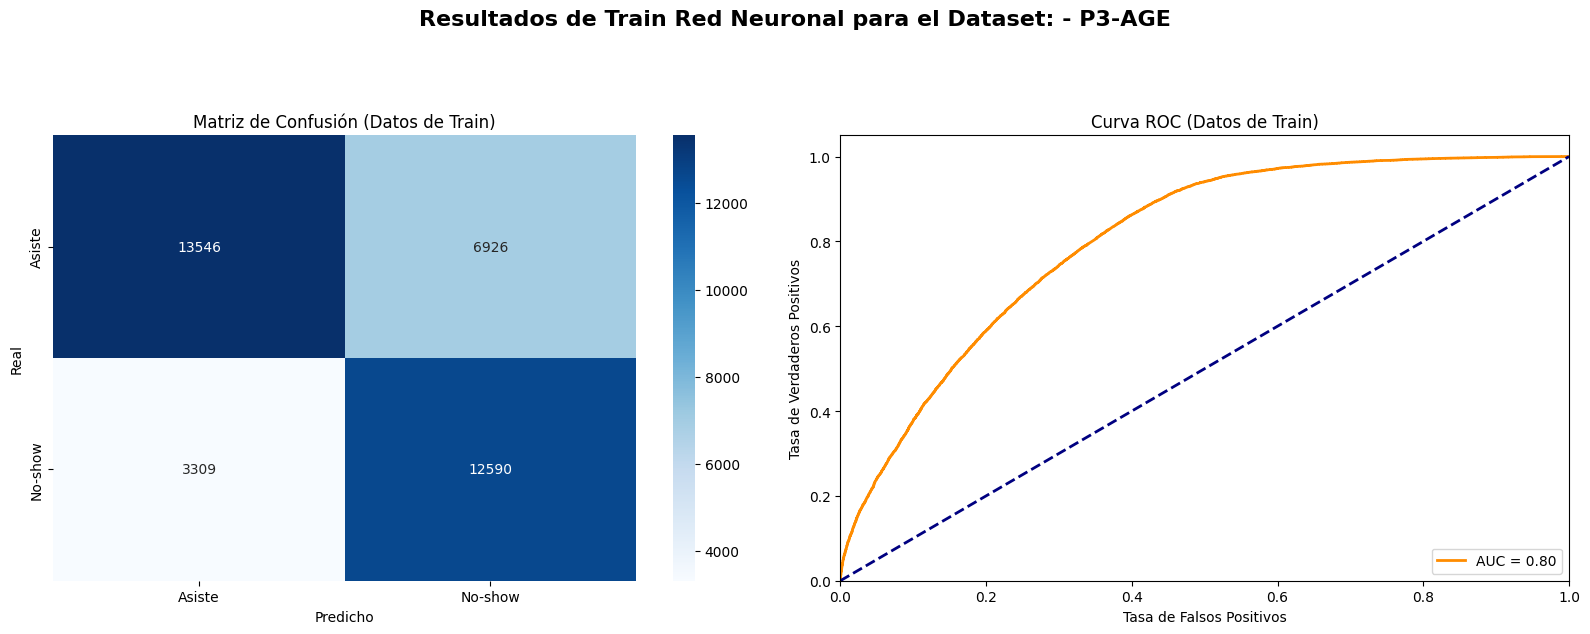

.........................
Resultados datos de test:
Accuracy (Datos de Test): 0.6226582091753946
Precision (Datos de Test): 0.3574603174603175
Recall (Datos de Test): 0.6783132530120481
F1 Score (Datos de Test): 0.4681912681912682
[[3095 2024]
 [ 534 1126]]


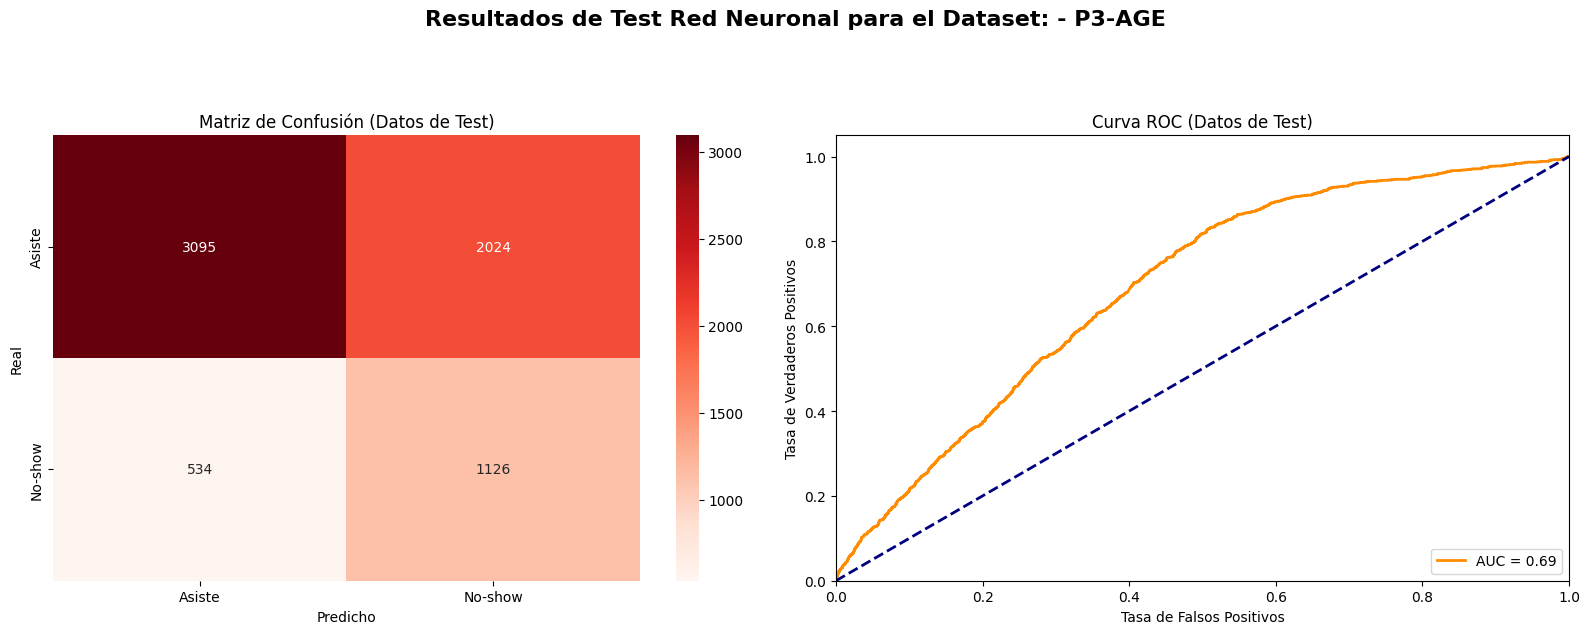

Modelo cargado exitosamente.
..................................
Resultados datos de entrenamiento:
Accuracy (Datos de Train): 0.6859036045200847
Precision (Datos de Train): 0.6020338364722514
Recall (Datos de Train): 0.8303666897289138
F1 Score (Datos de Train): 0.6980014803849001
[[11745  8727]
 [ 2697 13202]]


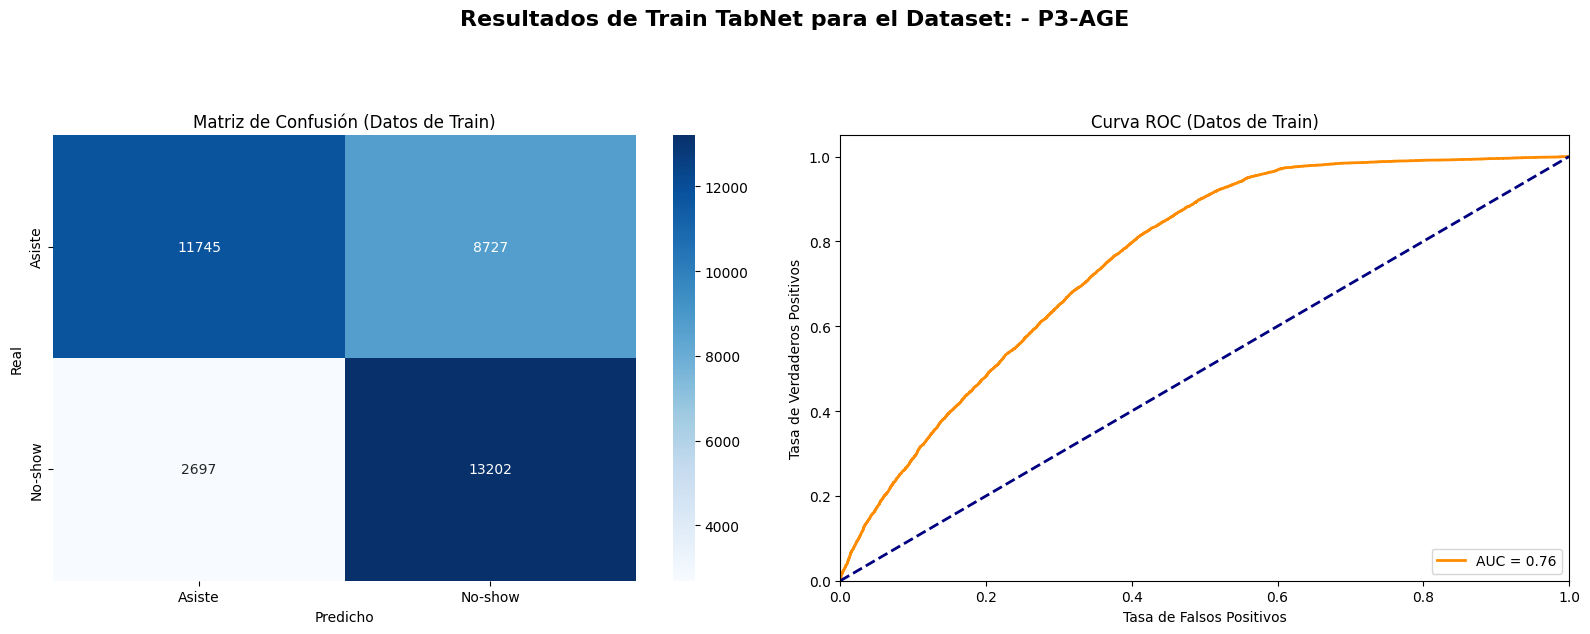

.........................
Resultados datos de test:
Accuracy (Datos de Test): 0.6318041008998377
Precision (Datos de Test): 0.3667941363926068
Recall (Datos de Test): 0.6933734939759036
F1 Score (Datos de Test): 0.47978324301792413
[[3132 1987]
 [ 509 1151]]


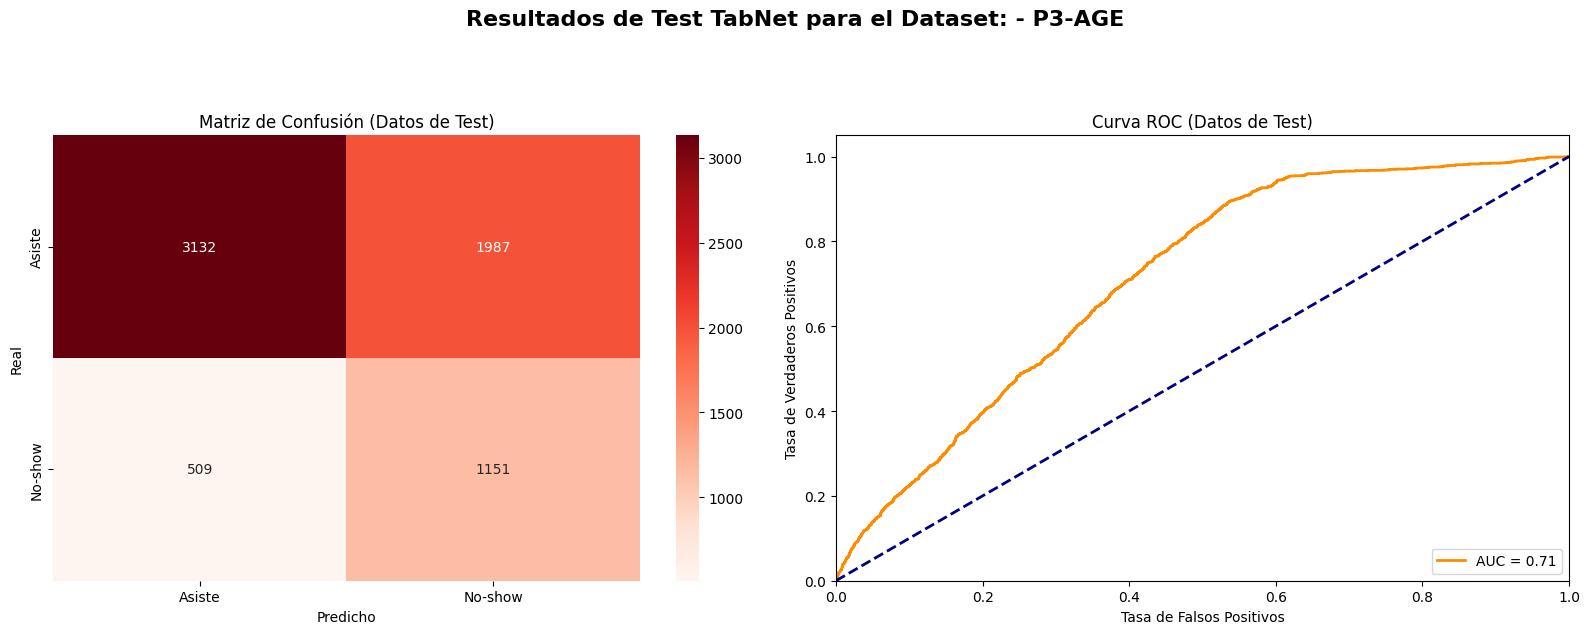


Ejecutando modelo para el dataset: P4-TIME

Modelo cargado exitosamente.
Mejores hiperparámetros cargados: {'C': 0.01, 'max_iter': 100, 'solver': 'lbfgs'}
..................................
Resultados datos de entrenamiento:
Accuracy (Datos de Train): 0.6278060006078764
Precision (Datos de Train): 0.5902984474298125
Recall (Datos de Train): 0.2624369657737563
F1 Score (Datos de Train): 0.363339275103981
[[36039  5093]
 [20623  7338]]


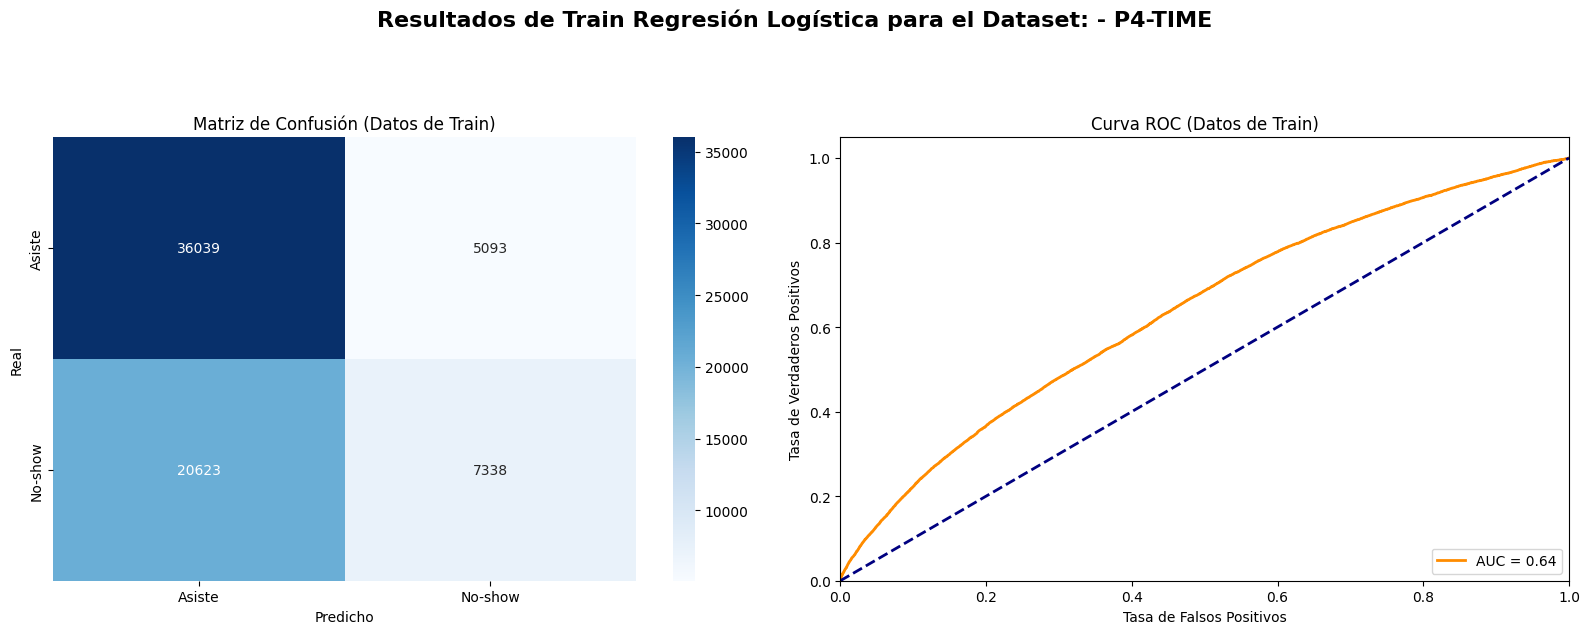

.........................
Resultados datos de test:
Accuracy (Datos de Test): 0.6736878693083073
Precision (Datos de Test): 0.3885542168674699
Recall (Datos de Test): 0.2515845928815212
F1 Score (Datos de Test): 0.30541580349215747
[[8659 1624]
 [3070 1032]]


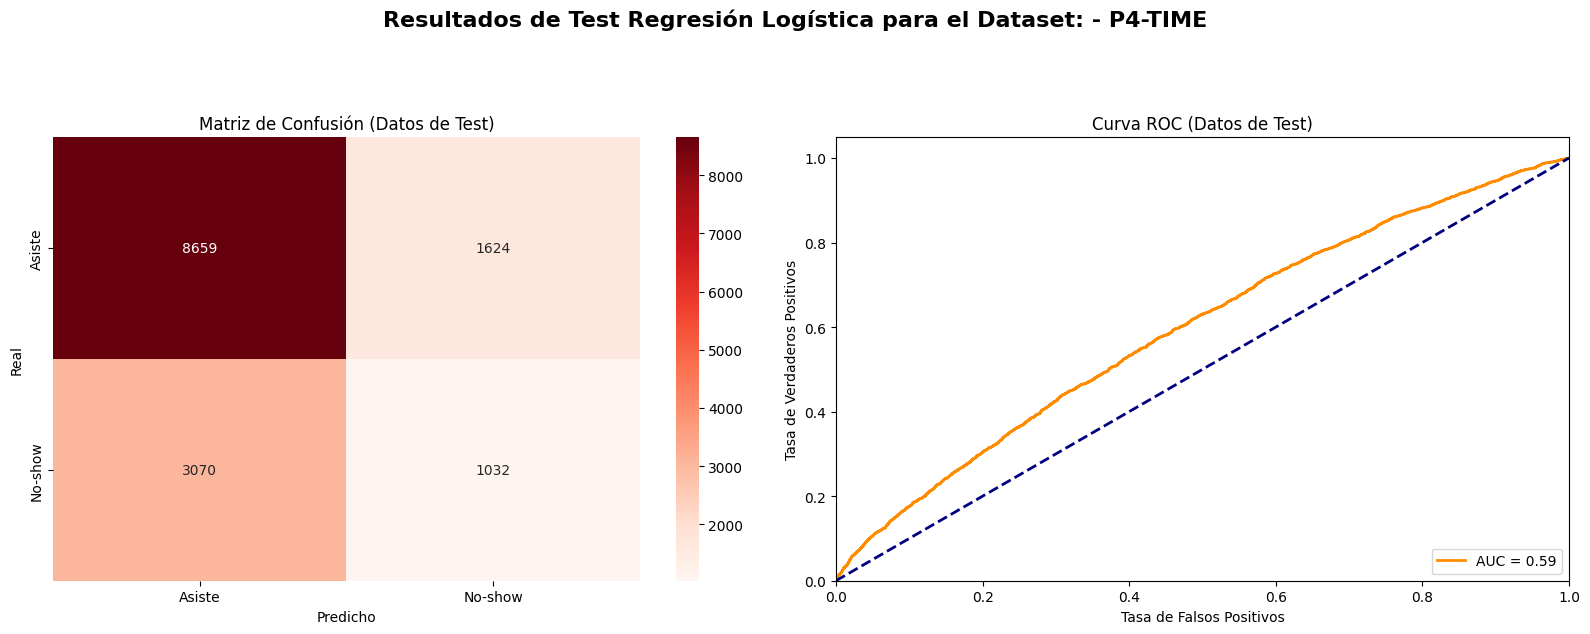

Modelo cargado exitosamente.
Mejores hiperparámetros cargados: {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2}
..................................
Resultados datos de entrenamiento:
Accuracy (Datos de Train): 0.8113991287105785
Precision (Datos de Train): 0.8837257119358487
Recall (Datos de Train): 0.6148564071385143
F1 Score (Datos de Train): 0.7251713592744912
[[38870  2262]
 [10769 17192]]


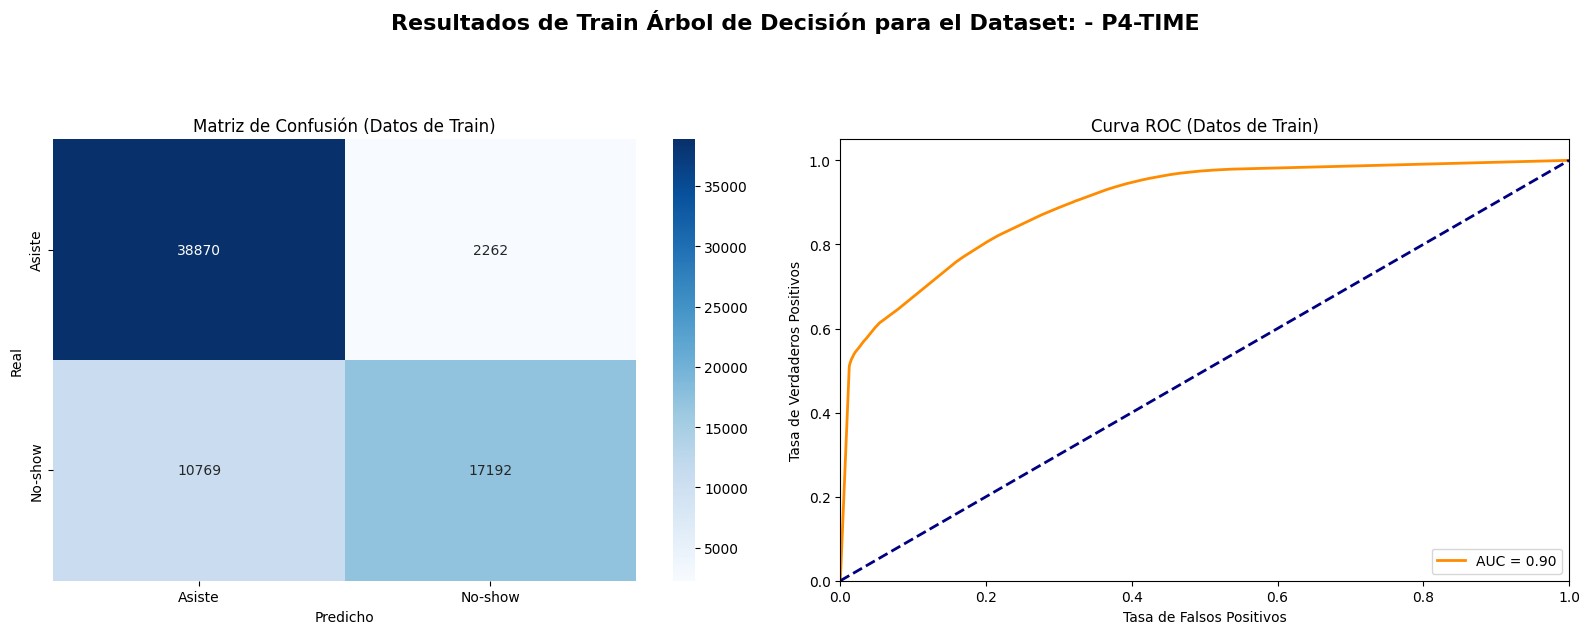

.........................
Resultados datos de test:
Accuracy (Datos de Test): 0.6511644073687869
Precision (Datos de Test): 0.3176751592356688
Recall (Datos de Test): 0.1945392491467577
F1 Score (Datos de Test): 0.24130631992742668
[[8569 1714]
 [3304  798]]


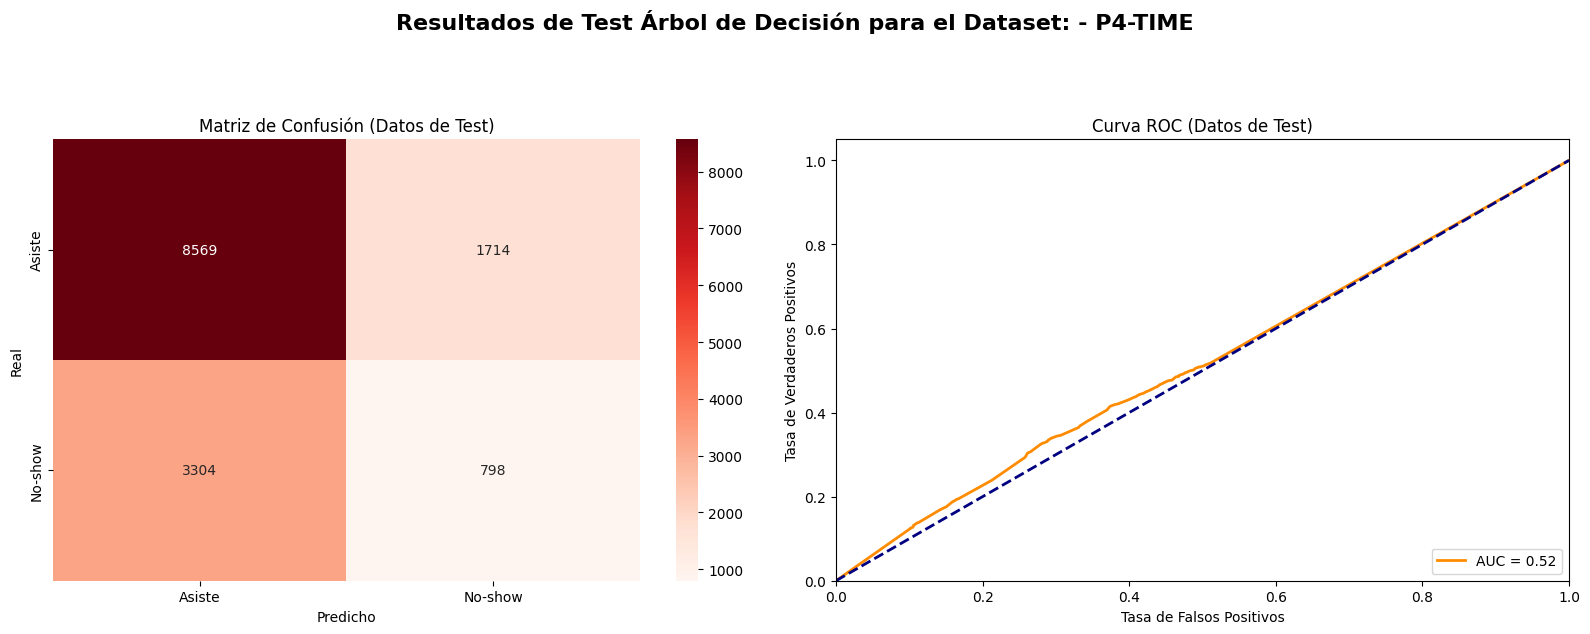

Modelo cargado exitosamente.
..................................
Resultados datos de entrenamiento:
Accuracy (Datos de Train): 0.6684324027036024
Precision (Datos de Train): 0.6505542972940755
Recall (Datos de Train): 0.3903651514609635
F1 Score (Datos de Train): 0.4879411698965109
[[35269  5863]
 [17046 10915]]


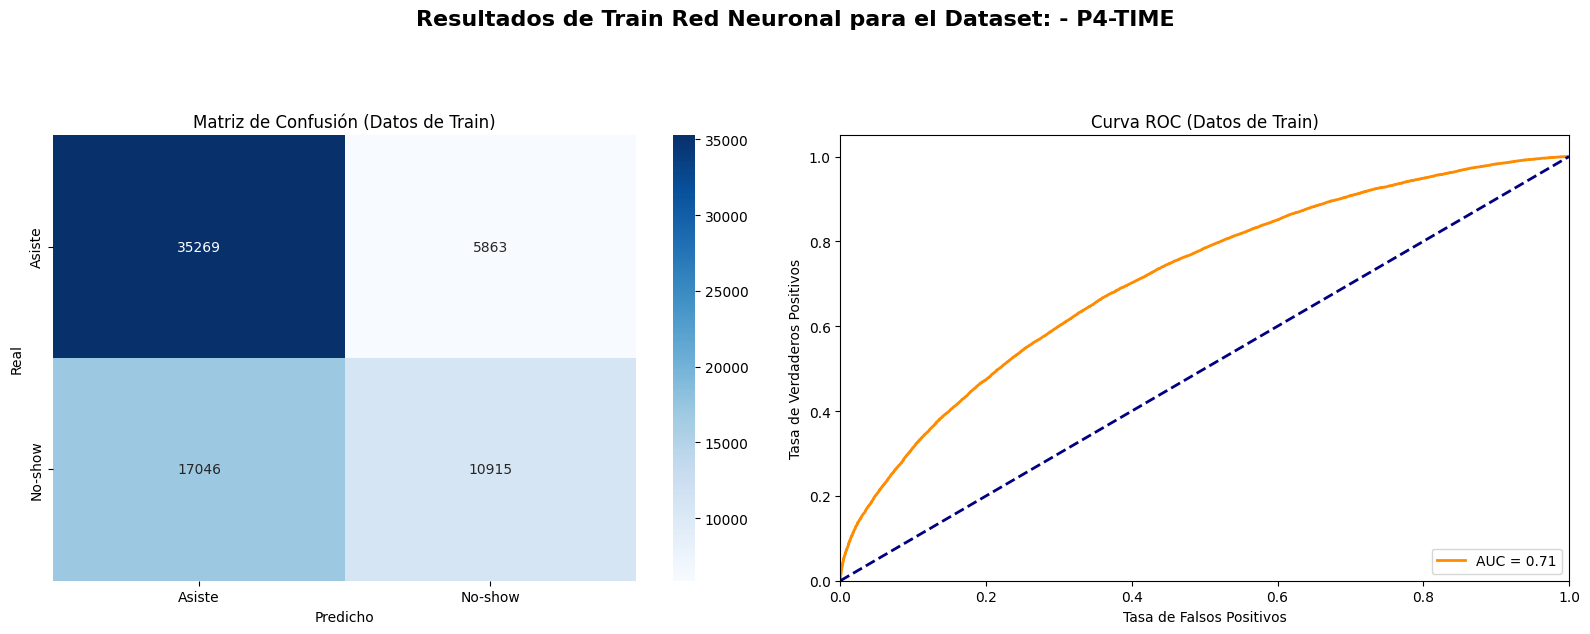

.........................
Resultados datos de test:
Accuracy (Datos de Test): 0.6440736878693083
Precision (Datos de Test): 0.3597796143250689
Recall (Datos de Test): 0.31838127742564604
F1 Score (Datos de Test): 0.33781686497672014
[[7959 2324]
 [2796 1306]]


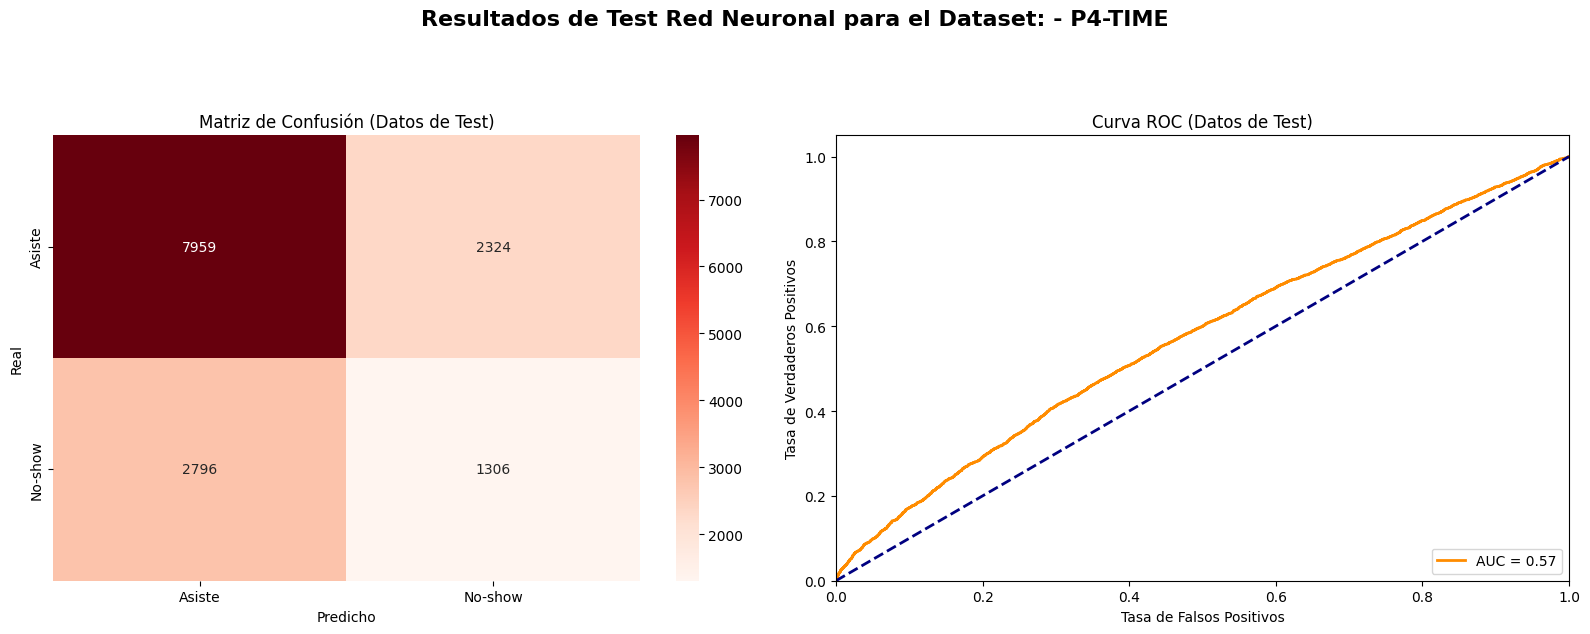

Modelo cargado exitosamente.
..................................
Resultados datos de entrenamiento:
Accuracy (Datos de Train): 0.6439002503871594
Precision (Datos de Train): 0.6055063171789553
Recall (Datos de Train): 0.34451557526554843
F1 Score (Datos de Train): 0.43916115796671984
[[34856  6276]
 [18328  9633]]


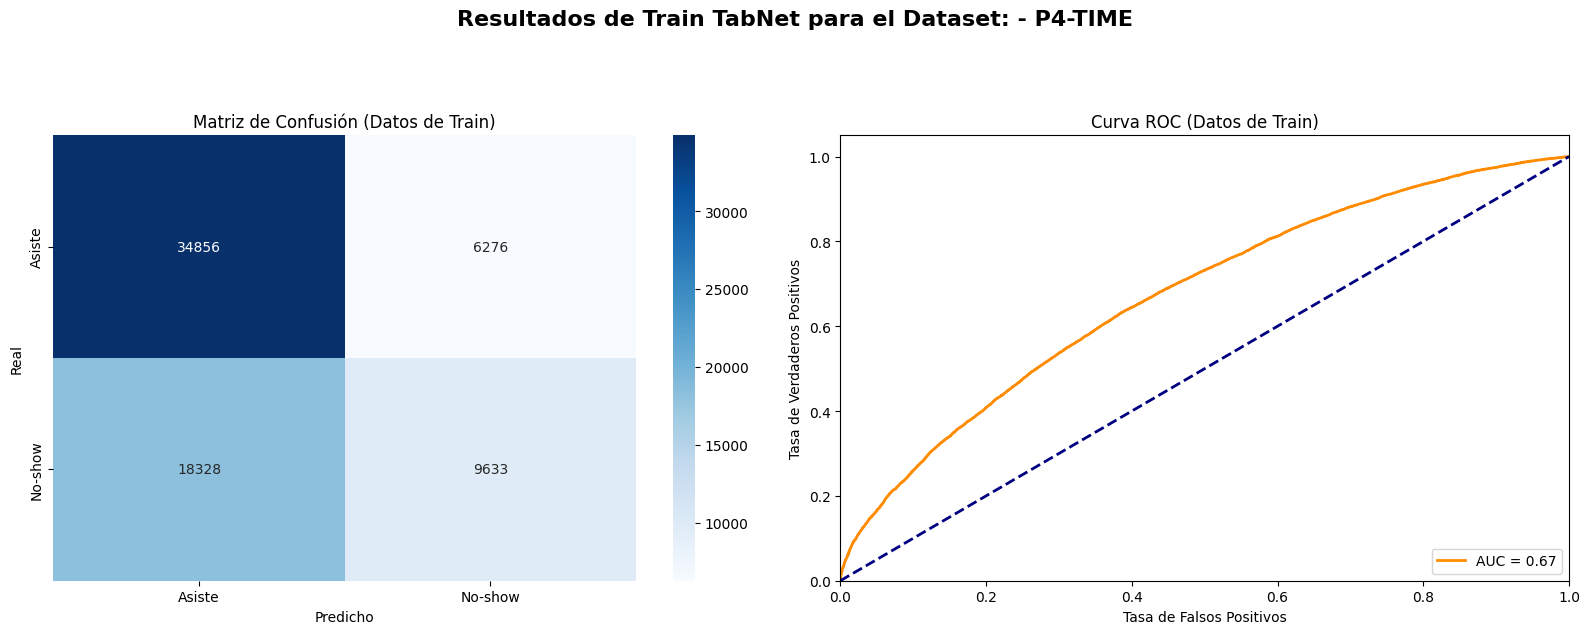

.........................
Resultados datos de test:
Accuracy (Datos de Test): 0.6967674661105318
Precision (Datos de Test): 0.39666136724960255
Recall (Datos de Test): 0.12164797659678206
F1 Score (Datos de Test): 0.18619402985074626
[[9524  759]
 [3603  499]]


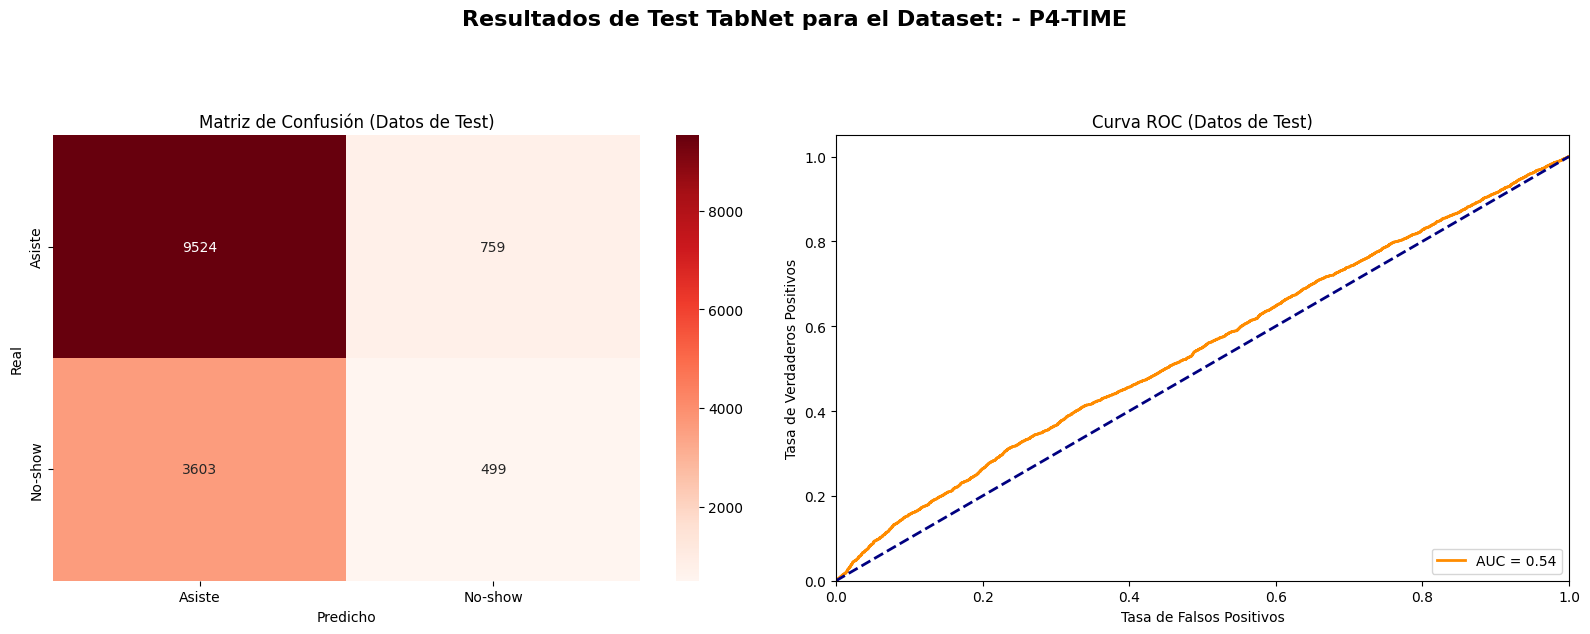


Ejecutando modelo para el dataset: P5-HEALTHCENTRE

Modelo cargado exitosamente.
Mejores hiperparámetros cargados: {'C': 1, 'max_iter': 100, 'solver': 'newton-cg'}
..................................
Resultados datos de entrenamiento:
Accuracy (Datos de Train): 0.6466068985733828
Precision (Datos de Train): 0.6444564964747811
Recall (Datos de Train): 0.4571459976367783
F1 Score (Datos de Train): 0.5348766176352383
[[36303  9178]
 [19755 16636]]


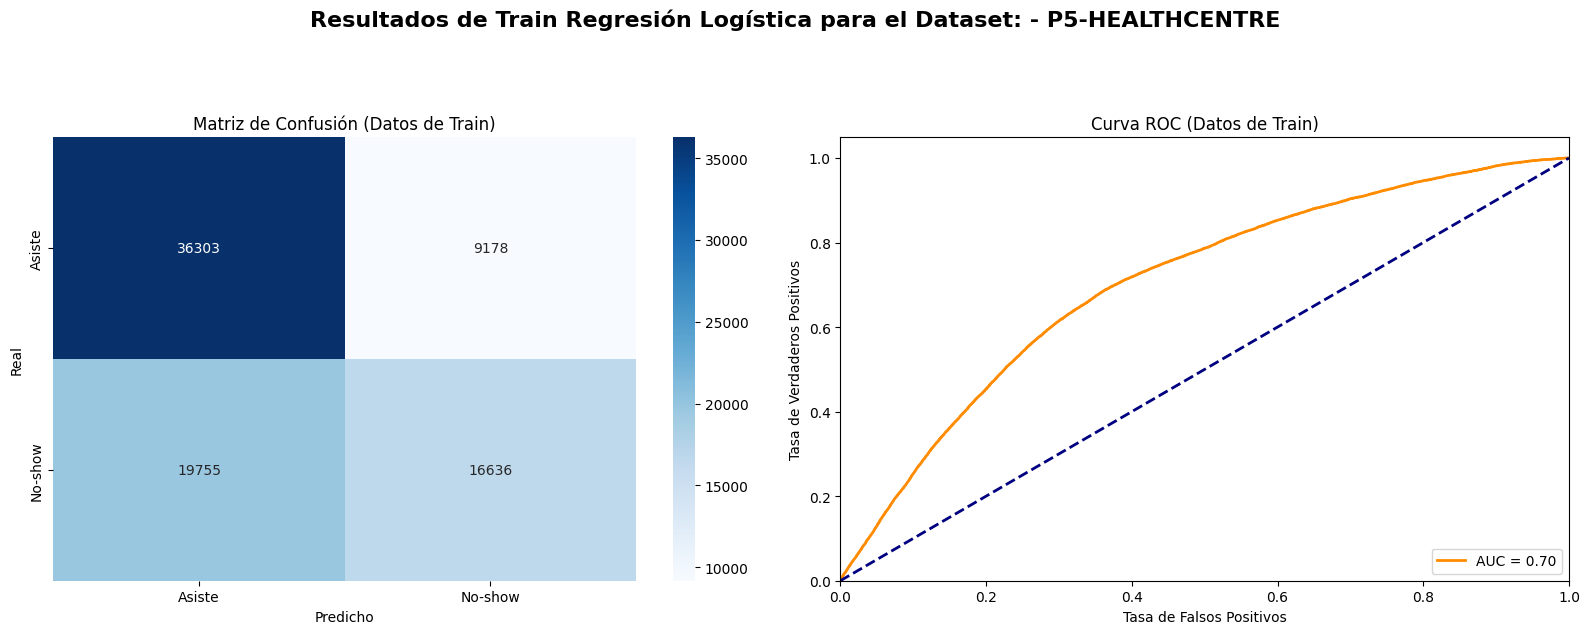

.........................
Resultados datos de test:
Accuracy (Datos de Test): 0.6919195458686663
Precision (Datos de Test): 0.33115271824949244
Recall (Datos de Test): 0.5063815108658158
F1 Score (Datos de Test): 0.4004364429896345
[[8405 2965]
 [1431 1468]]


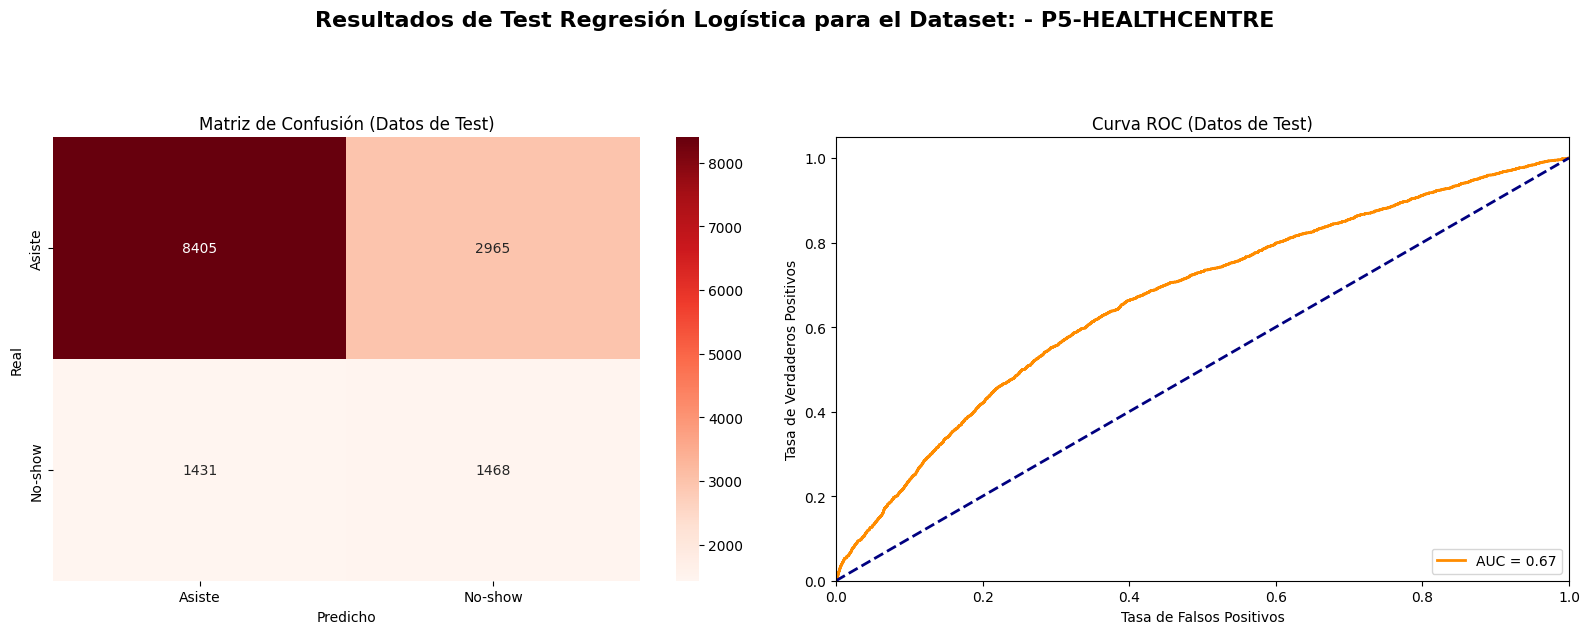

Modelo cargado exitosamente.
Mejores hiperparámetros cargados: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2}
..................................
Resultados datos de entrenamiento:
Accuracy (Datos de Train): 0.8356336720734806
Precision (Datos de Train): 0.8012557797393863
Recall (Datos de Train): 0.8380918358934901
F1 Score (Datos de Train): 0.8192599556779263
[[37916  7565]
 [ 5892 30499]]


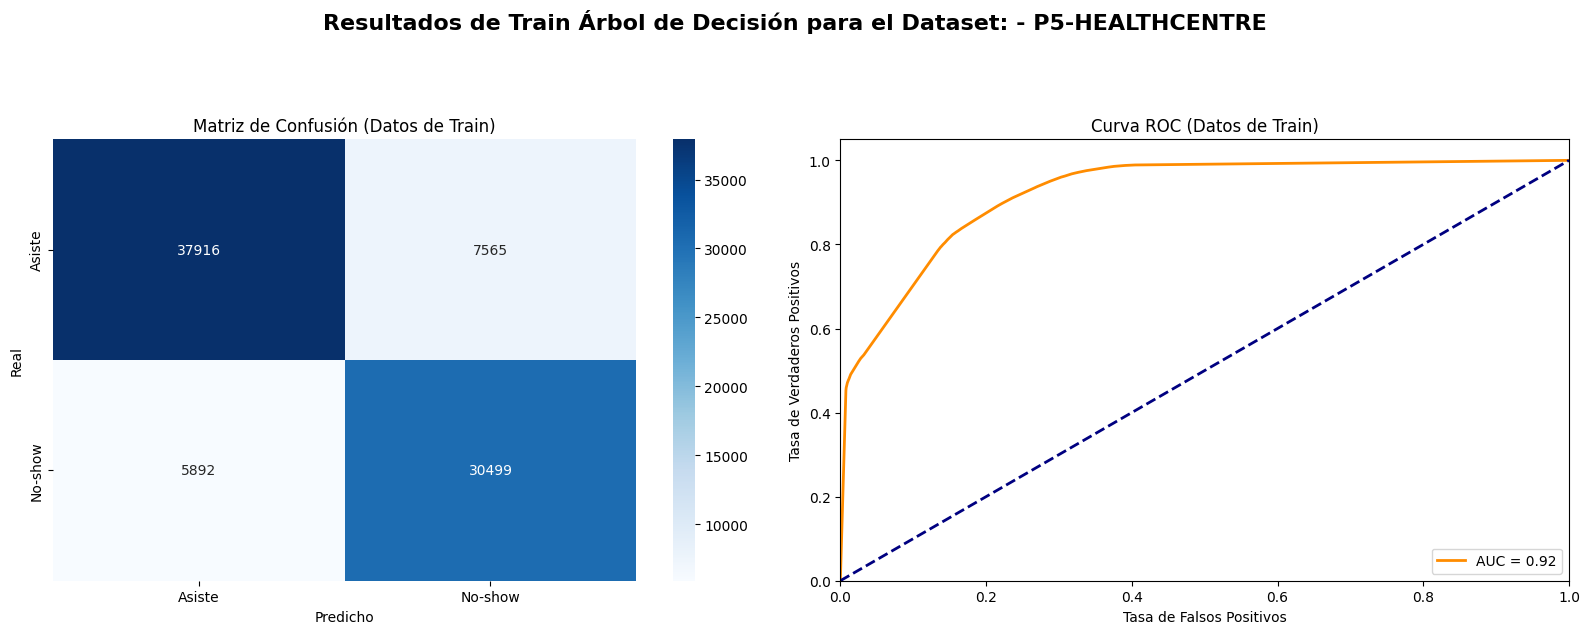

.........................
Resultados datos de test:
Accuracy (Datos de Test): 0.7168687364216133
Precision (Datos de Test): 0.3373253493013972
Recall (Datos de Test): 0.4080717488789238
F1 Score (Datos de Test): 0.3693412425850765
[[9046 2324]
 [1716 1183]]


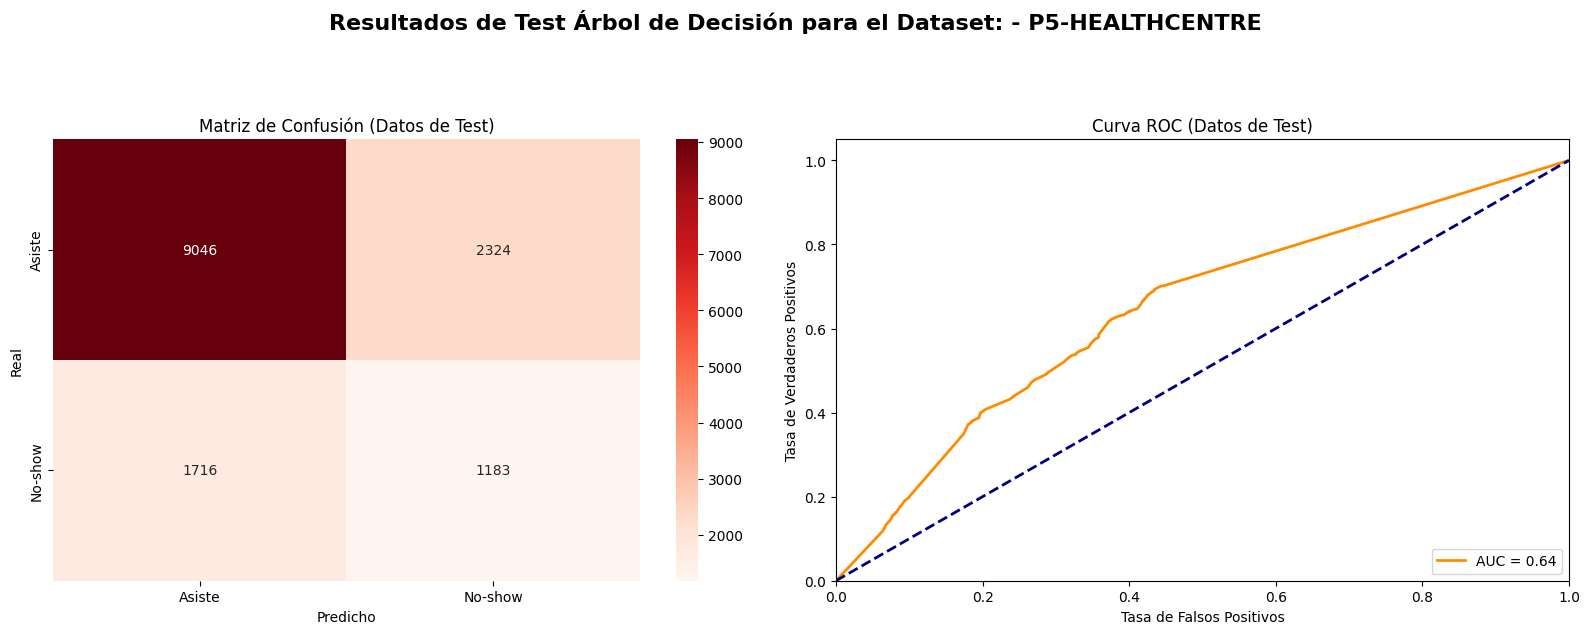

Modelo cargado exitosamente.
..................................
Resultados datos de entrenamiento:
Accuracy (Datos de Train): 0.7230799296462771
Precision (Datos de Train): 0.6586048232329071
Recall (Datos de Train): 0.7827210024456597
F1 Score (Datos de Train): 0.7153189352084379
[[30716 14765]
 [ 7907 28484]]


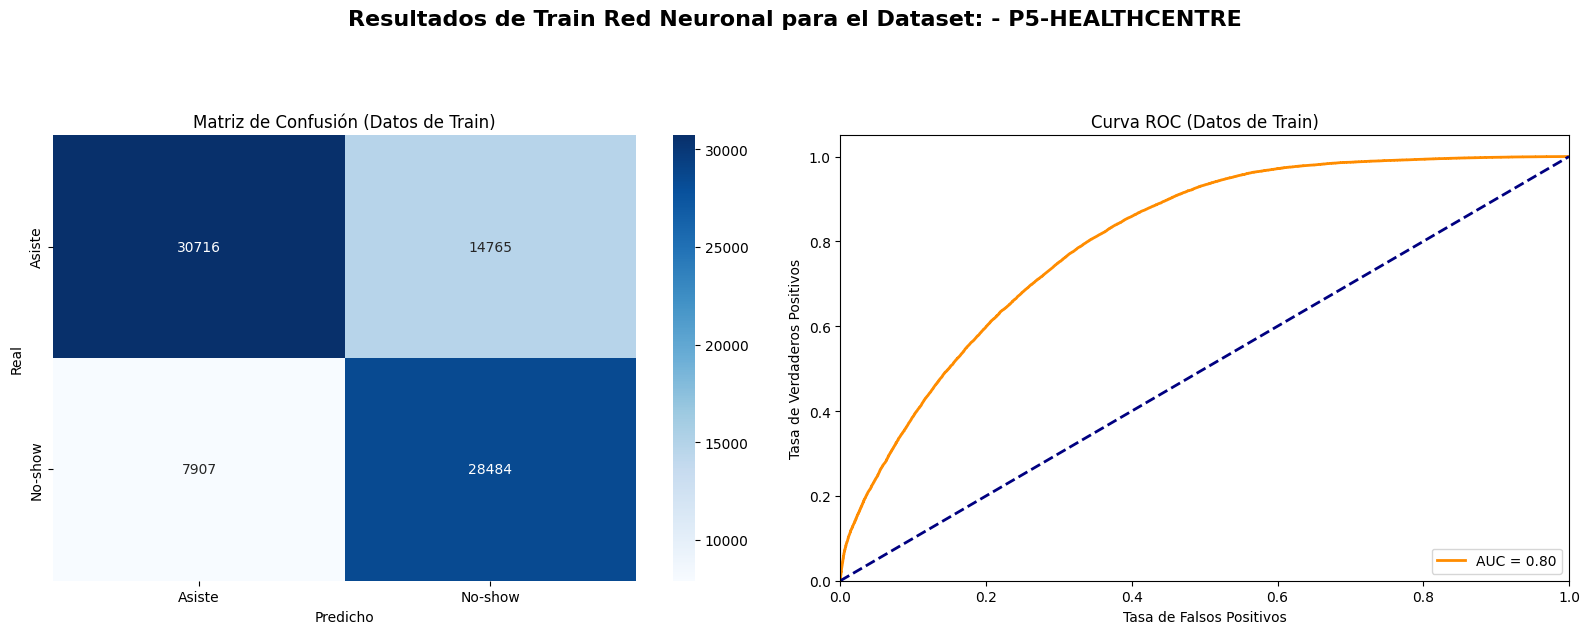

.........................
Resultados datos de test:
Accuracy (Datos de Test): 0.6096432826406896
Precision (Datos de Test): 0.3028782287822878
Recall (Datos de Test): 0.7078302863056226
F1 Score (Datos de Test): 0.4242298945627455
[[6647 4723]
 [ 847 2052]]


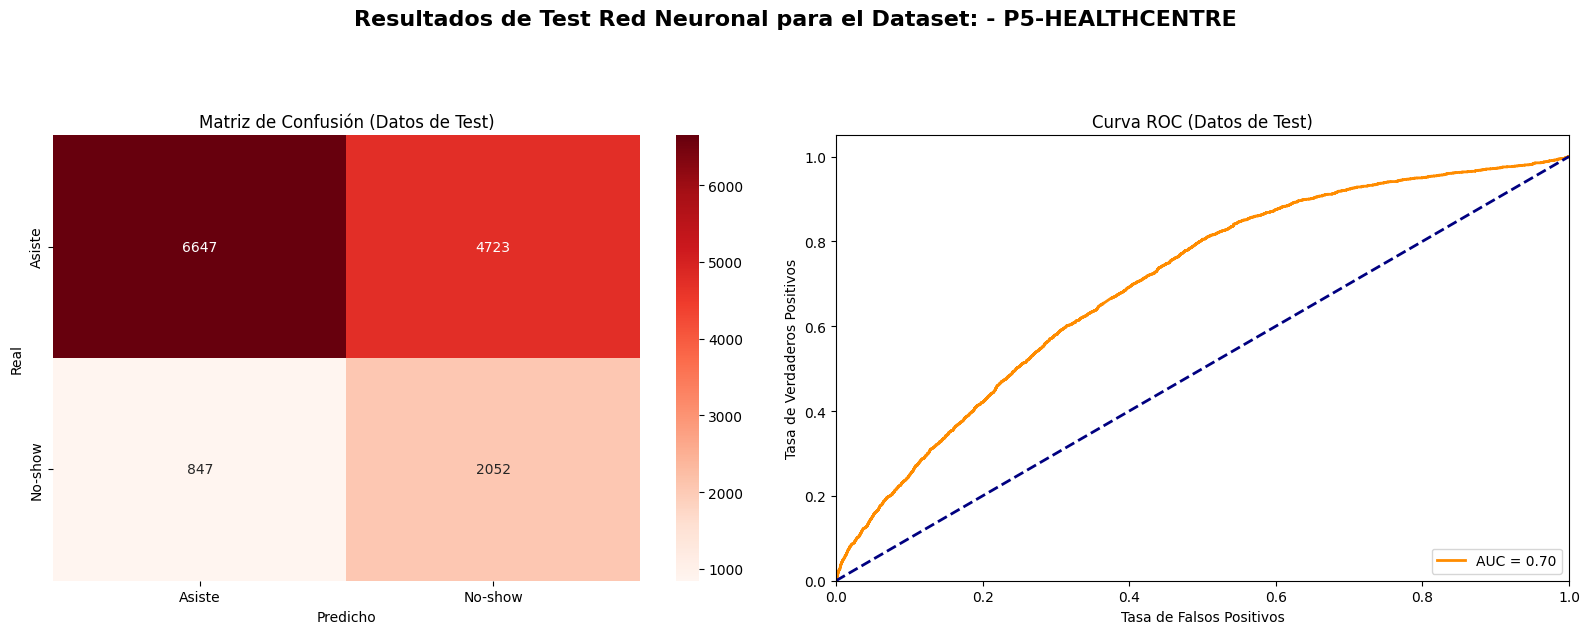

Modelo cargado exitosamente.
..................................
Resultados datos de entrenamiento:
Accuracy (Datos de Train): 0.7154338479577877
Precision (Datos de Train): 0.6544459386132541
Recall (Datos de Train): 0.7622763870187684
F1 Score (Datos de Train): 0.7042575338292416
[[30834 14647]
 [ 8651 27740]]


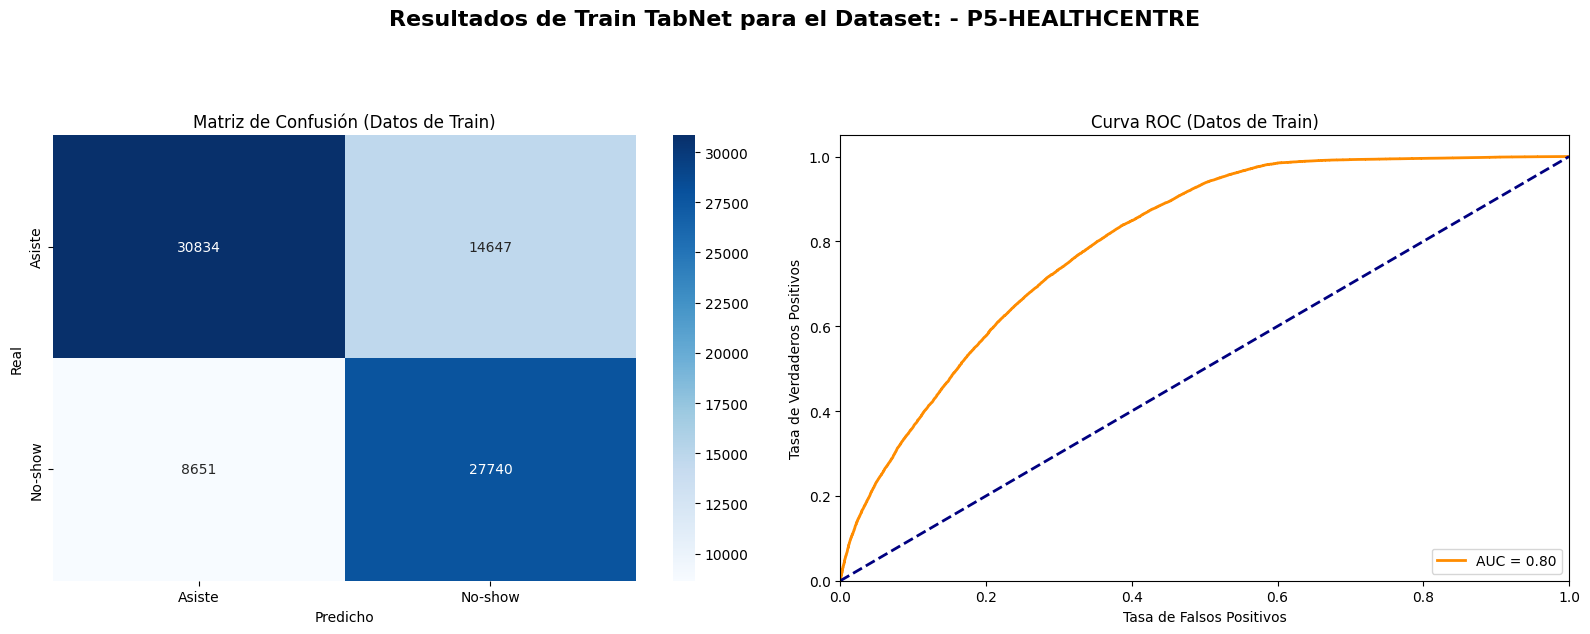

.........................
Resultados datos de test:
Accuracy (Datos de Test): 0.6841404443198542
Precision (Datos de Test): 0.3414826498422713
Recall (Datos de Test): 0.5974473956536737
F1 Score (Datos de Test): 0.4345753355915193
[[8030 3340]
 [1167 1732]]


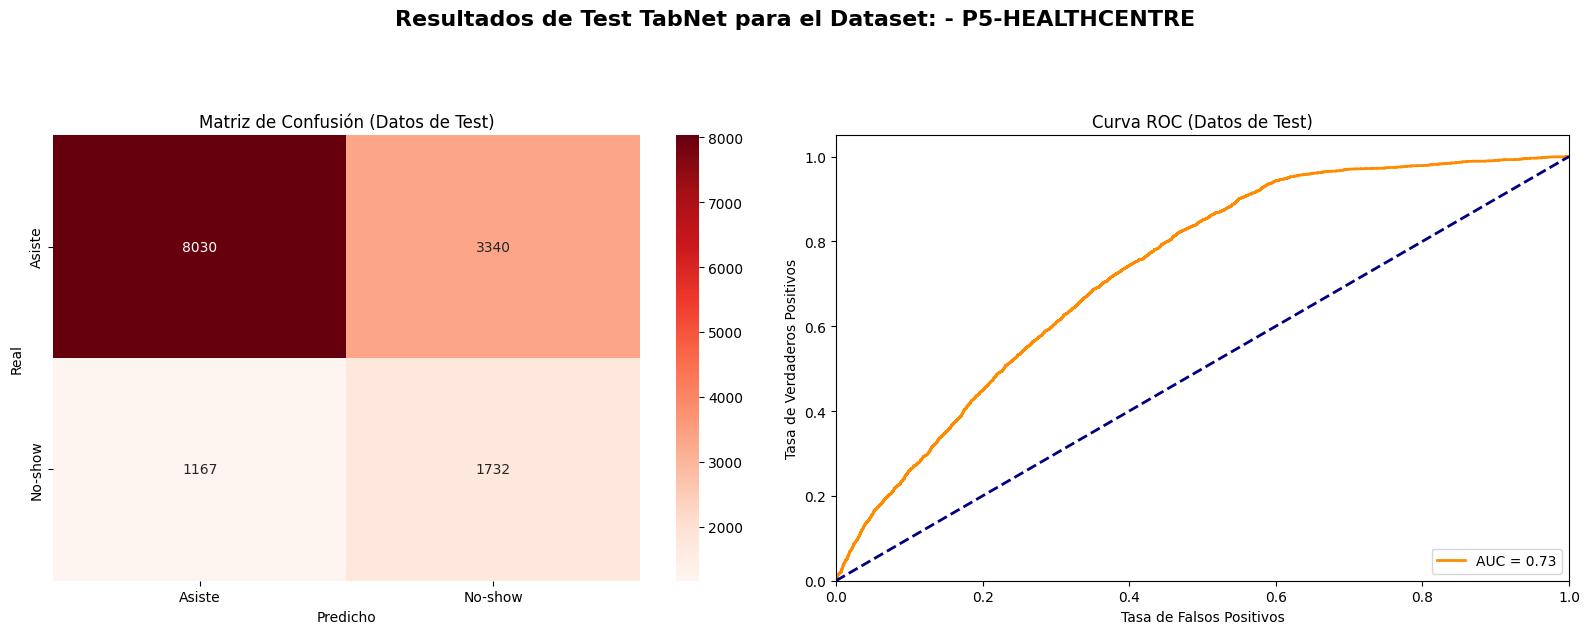

In [10]:
def load_data(file_path):
    return joblib.load(file_path)

# Listado de archivos
X_test_files = [
    "X_test_P1-ALL-ADASYN.pkl", "X_test_P1-ALL.pkl", "X_test_P2-NOCONDITIONS.pkl", 
    "X_test_P3-AGE.pkl", "X_test_P4-TIME.pkl", "X_test_P5-HEALTHCENTRE.pkl"
]

X_train_files = [
    "X_train_P1-ALL-ADASYN.pkl", "X_train_P1-ALL.pkl", "X_train_P2-NOCONDITIONS.pkl", 
    "X_train_P3-AGE.pkl", "X_train_P4-TIME.pkl", "X_train_P5-HEALTHCENTRE.pkl"
]

y_test_files = [
    "y_test_P1-ALL-ADASYN.pkl", "y_test_P1-ALL.pkl", "y_test_P2-NOCONDITIONS.pkl", 
    "y_test_P3-AGE.pkl", "y_test_P4-TIME.pkl", "y_test_P5-HEALTHCENTRE.pkl"
]

y_train_files = [
    "y_train_P1-ALL-ADASYN.pkl", "y_train_P1-ALL.pkl", "y_train_P2-NOCONDITIONS.pkl", 
    "y_train_P3-AGE.pkl", "y_train_P4-TIME.pkl", "y_train_P5-HEALTHCENTRE.pkl"
]

file_names = [
    "P1-ALL-ADASYN", "P1-ALL", "P2-NOCONDITIONS", 
    "P3-AGE", "P4-TIME", "P5-HEALTHCENTRE"
]

# Se cargan los archivos en un diccionario
data = {}
for file_list in [X_test_files, X_train_files, y_test_files, y_train_files]:
    for file_name in file_list:
        data[file_name] = load_data(file_name)

# Se crea bucle para analizar los datos con el modelo de PyTorch
for idx, (X_train_file, y_train_file, X_test_file, y_test_file) in enumerate(zip(X_train_files, y_train_files, X_test_files, y_test_files)):
    try:
        if X_train_file in data and y_train_file in data and X_test_file in data and y_test_file in data:
            X_train = data[X_train_file]
            y_train = data[y_train_file]
            X_test = data[X_test_file]
            y_test = data[y_test_file]

            dataset_name = file_names[idx]
            titulo = f"\n{'='*40}\nEjecutando modelo para el dataset: {dataset_name}\n{'='*40}\n"
            print(titulo)
            # Se ejecuta el modelo de regresión logística
            execute_model_logistic_regression(X_train, y_train, X_test, y_test, dataset_name)
            # Se ejecuta el modelo de árbol de decisión
            execute_model_decision_tree(X_train, y_train, X_test, y_test, dataset_name)
            # Se ejecuta el modelo de PyTorch
            execute_model_pytorch(X_train, y_train, X_test, y_test, device='cuda', dataset_name=dataset_name)
            # Se ejecuta el modelo de TabNet
            execute_model_tabnet(X_train, y_train, X_test, y_test, device='cuda', dataset_name=dataset_name)
        else:
            print(f"Archivos correspondientes no encontrados para {X_train_file}. Omitiendo este archivo.")
    except KeyError as e:
        print(f"Error: {e} - La clave no existe en el diccionario 'data'. Omitiendo este archivo.")